# [GN-5] Transformer


### 프로젝트 주제: Transformer 모델을 이용하여 한-영 번역기 구현하기
이번 프로젝트는 이전에 GRU를 이용한 Seq2Seq 한영 번역기에서 성능이 좋지 않았던 부분을 Transformer로 교체하여 번역기를 구현해 보며,   
Transformer 모델의 구조를 깊이있게 이해하는 것을 첫번째 목표로한다.   

### 추가 탐색 주제: BLEU Score 구현 비교
번역기의 품질 성능을 측정하기 위해 BLEU Score를 구현하고 비교해보자.



In [42]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import re
from konlpy.tag import Mecab
import random

import warnings
warnings.filterwarnings(action='ignore')

print(tf.__version__)
print(np.__version__)
print(plt.__version__)

2.10.1
1.23.5
3.7.1


## Step 1. 데이터 다운로드 (클라우드 유저용)

https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

## Step 2. 데이터 정제 및 토큰화

### 2-1 중복 값 제거

In [2]:
data_dir = "./korean_english"
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    print('kor:', len(kor), 'eng:',len(eng))

    dup_word_index = []
    unique_sen = set()
    i = 0
    for sen in kor[:]:
        if sen not in unique_sen:
            unique_sen.add(sen)
        else:
            dup_word_index.append(i)
        i +=1

    print('dup_word_index 갯수: ',len(dup_word_index), 'unique_sen 갯수: ', len(unique_sen))

    kor = np.delete(kor, dup_word_index).tolist()
    eng = np.delete(eng, dup_word_index).tolist()

    print('kor:', len(kor))

    unique_sen = set()
    result = []
    i = 0
    for sen in kor[:]:
        if sen not in unique_sen:
            unique_sen.add(sen)
            result.append(sen + ' \t ' + eng[i] )
        i +=1

    print('result', len(result))

    return result

cleaned_corpus = clean_corpus(kor_path, eng_path)

kor: 94123 eng: 94123
dup_word_index 갯수:  16532 unique_sen 갯수:  77591
kor: 77591
result 77591


### 2-2 정제 함수
- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다.
- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [3]:

def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

print("슝~")

슝~


### 2-3 토큰화
- kor_corpus, eng_corpus 분리
- generate_tokenizer()함수 정의


In [4]:
import sentencepiece as spm
import os

def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):

    temp_file = './transformer/sp.temp'.format(type)

    with open(temp_file, 'w') as f:
        for row in corpus:   
            f.write(str(row) + '\n')

    templates= '--input={} \
    --pad_id={} \
    --bos_id={} \
    --eos_id={} \
    --unk_id={} \
    --model_prefix={} \
    --vocab_size={} \
    --character_coverage={} \
    --model_type={}'

    train_input_file = temp_file
    prefix = '{}_spm'.format(lang)         # 저장될 tokenizer 모델에 붙는 이름

    pad_id=pad_id  #<pad> token을 0으로 설정
    bos_id=bos_id #<start> token을 1으로 설정
    eos_id=eos_id #<end> token을 2으로 설정
    unk_id=unk_id #<unknown> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set 

    vocab_size = vocab_size # vocab 사이즈
    model_type ='unigram' # Choose from unigram (default), bpe, char, or word

    cmd = templates.format(train_input_file,
                    pad_id,
                    bos_id,
                    eos_id,
                    unk_id,
                    prefix,
                    vocab_size,
                    character_coverage,
                    model_type)

    spm.SentencePieceTrainer.Train(cmd)

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('{}.model'.format(prefix))
    
    return tokenizer

🧐 프로젝트 폴더에 en_spm.model, en_spm.vocab, ko_spm.model, ko_spm.vocab이 만들어진다.   
SentencePiece를 이용해 토큰화하도록 함수를 구현했다.

In [5]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))


ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")


True

In [6]:
cleaned_corpus[:10]

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?" \t Much of personal computing is about "can you top this?"',
 '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다. \t so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.',
 "그러나 이것은 또한 책상도 필요로 하지 않는다. \t Like all optical mice, But it also doesn't need a desk.",
 '79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다. \t uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.',
 "정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다. \t Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.",
 "이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에

In [7]:
tokensIDs = ko_tokenizer.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)
print(ko_tokenizer.DecodeIds(tokensIDs))

[861, 11, 785, 10, 3221, 11, 653, 39, 3]
아버지가방에들어가신다 ⁇ 


In [8]:
tokensIDs = en_tokenizer.EncodeAsIds('Much of personal computing is about "can you top this?"')
print(tokensIDs)
print(en_tokenizer.DecodeIds(tokensIDs))

[1, 37, 3, 215, 7, 1358, 8184, 12, 18, 49, 37, 3, 6540, 95, 225, 44, 3, 2]
 ⁇ uch of personal computing is about  ⁇ can you top this ⁇ 


🧐 토큰화가 잘 진행되어서 문장과 인덱스 간에 변환이 잘 되는 것을 확인했다.

### 2-4 Train데이터 변환
- 토큰 길이 50 이하 선별 src_corpus, tgt_corpus를 텐서 enc_train, dec_train

In [9]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
      if len(ko_tokenizer.EncodeAsIds(kor_corpus[idx]))<=50:
            src_corpus.append(ko_tokenizer.EncodeAsIds(kor_corpus[idx]))
            tgt_corpus.append(en_tokenizer.EncodeAsIds(eng_corpus[idx]))

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')


  0%|          | 0/77591 [00:00<?, ?it/s]

In [10]:
enc_train[0]

array([ 1113,   348,   549,   505,     6,  1363,  1952,     8,  1273,
         223,  2788,   976,    26, 10781,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [11]:
dec_train[0]

array([   1,  308,    7, 1358, 8184,   12,   18,   49,  102,   95,  225,
         44,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])

🧐 enc_train이 50이하의 토큰으로 잘 구성되어 텐서로 만들어진 것을 확인했다. 

## Step 3. 모델 설계

### 3-1 positional_encoding

In [12]:
# positional_encoding
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

🧐 sin, cos 값을 이용하여 position정보를 저장하는 함수   
기존 RNN에서는 입력값을 순차적으로 토큰의 위치를 알았지만, 병렬처리하는 Transformer를 위해 토큰의 위치정보를 넣어주기 위한 함수

### 3-2 MultiHeadAttention

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        """
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)

        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

print("슝=3")

슝=3


### 3-3 PoswiseFeedForwardNet

In [14]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


### 3-4 EncoderLayer

In [15]:
#Encoder Layer 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


### 3-5 DecoderLayer

In [16]:
# Decoder 레이어 구현하기
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [18]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [19]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [20]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


## Step 4. 훈련하기

### 4-1 Transformer 선언

In [21]:

n_layers = 2            # encoder, decoder layer를 각각 2개층 쌓음
d_model = 512           # dense층 및 모든 모델의 dimention 
n_heads = 8             # multiheadattention을 위한 head 갯수
d_ff = 2048             # FeedForward 층의 dimention   
dropout = 0.3           


src_vocab_size = SRC_VOCAB_SIZE
tgt_vocab_size = TGT_VOCAB_SIZE
pos_len = 600           # position endoding의 최대값

warmup_steps = 4000     #learning rate


transformer = Transformer(
        n_layers,
        d_model,
        n_heads,
        d_ff,
        src_vocab_size,
        tgt_vocab_size,
        pos_len,
        dropout
)


### 4-2 Learning Rate Scheduler

In [84]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)



learning_rate = LearningRateScheduler(d_model, warmup_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)



print("슝=3")

슝=3


### 4-3 Loss 함수 정의

In [23]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 4-4 Train 함수 정의 

In [24]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 4-5 학습 준비

In [25]:
import matplotlib.pyplot as plt

In [108]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [27]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [121]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
        #plot_attention(dec_attns, sentence.split(), result.split())
        

### 4-6 Training

In [29]:
# 학습

#from tqdm import tqdm_notebook 
from tqdm.notebook import tqdm

BATCH_SIZE = 64
EPOCHS = 5

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 30
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
  
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

  0%|          | 0/1186 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president obama is expected to obama to obama s president obama s president obama s president obama s president obama s president obama said obama s campaign obama s campaign
Input: 시민들은 도시 속에 산다.
Predicted translation: the cause of the city such as the city of the city
Input: 커피는 필요 없다.
Predicted translation: we are not to because it is not to because it is not to because
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the incident were injured in the incident


  0%|          | 0/1186 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city of the city of the city of the city of the city of the city
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll from the death toll from the death toll from the death toll


  0%|          | 0/1186 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s first president obama s president s president
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban
Input: 커피는 필요 없다.
Predicted translation: don t need to be
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was the second largest city


  0%|          | 0/1186 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban city is the city of urban
Input: 커피는 필요 없다.
Predicted translation: coffee is no need to be coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and another 26 were wounded in the crash


  0%|          | 0/1186 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s margin of president barack obama is obama
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens live in cities
Input: 커피는 필요 없다.
Predicted translation: coffee shops don t need coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a total of seven people were killed


## Step 5.훈련결과 

### 5-1 번역 결과

In [33]:
trans_list=[]
print('예문')
print('='*50)
for idx, sen in enumerate(examples):
    print(f'> {str(idx+1)}. {sen}')

    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sen, transformer, ko_tokenizer, en_tokenizer)
    trans_list.append(result)
print('\n')
print('번역문')
print('='*50)
for idx, sen in enumerate(trans_list):
    print(f'> {str(idx+1)}. {sen}')

print('\n')
print('Hyperparameters')
print('='*50)

print('n_layers :',n_layers)
print('d_model :',d_model)
print('n_heads :',n_heads)
print('d_ff :',d_ff)
print('dropout :',dropout)

print('\n')
print('Hyperparameters')
print('='*50)
print('Warmup_steps :',warmup_steps)
print('BATCH_SIZE  :',BATCH_SIZE )
print('EPOCHS  :',EPOCHS )


예문
> 1. 오바마는 대통령이다.
> 2. 시민들은 도시 속에 산다.
> 3. 커피는 필요 없다.
> 4. 일곱 명의 사망자가 발생했다.


번역문
> 1. obama s margin of president barack obama is obama
> 2. citizens live in cities
> 3. coffee shops don t need coffee
> 4. a total of seven people were killed


Hyperparameters
n_layers : 2
d_model : 512
n_heads : 8
d_ff : 2048
dropout : 0.3


Hyperparameters
Warmup_steps : 4000
BATCH_SIZE  : 64
EPOCHS  : 5


In [105]:
sen = '하늘이 풍선이 떠있다.'

pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sen, transformer, ko_tokenizer, en_tokenizer)
result

'the sky has plummeted'

😣 하늘이 수직으로 떨어진다고 흠.. 학습이 좀 더 필요해 보인다.

### 5-2 Attention Map 시작화

In [93]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams["font.family"] = "NanumGothic"
 
%config InlineBackend.figure_format = 'retina'

Input: 오바마는 대통령이다.
Predicted translation: obama s margin of president barack obama is obama
Encoder Layer 1


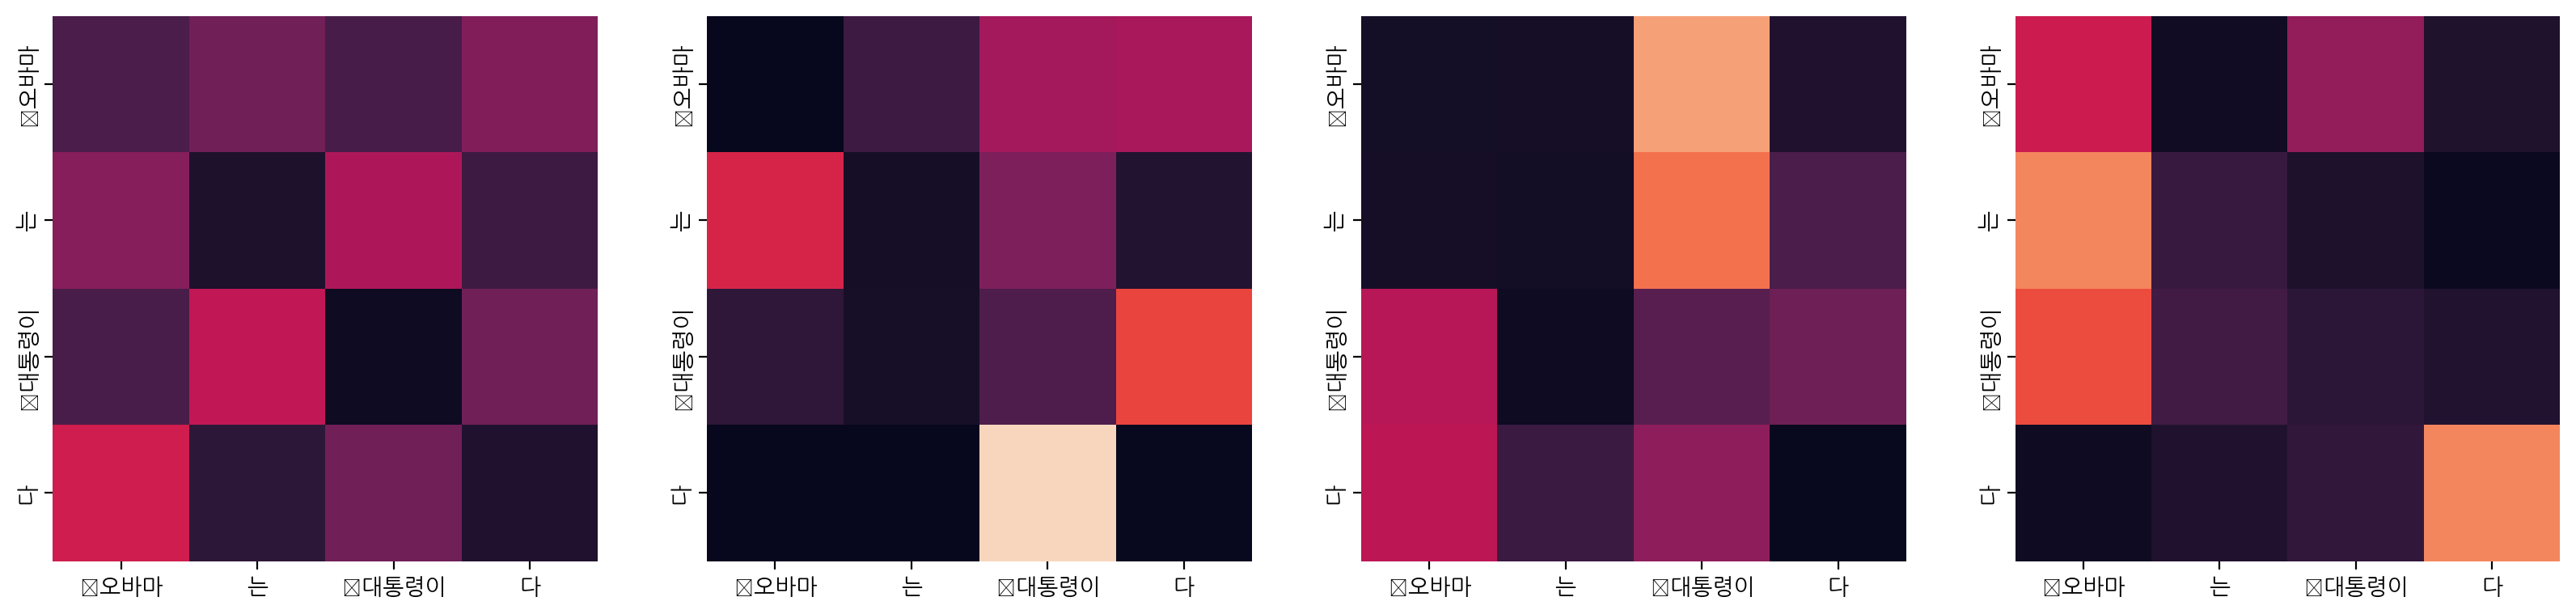

Encoder Layer 2


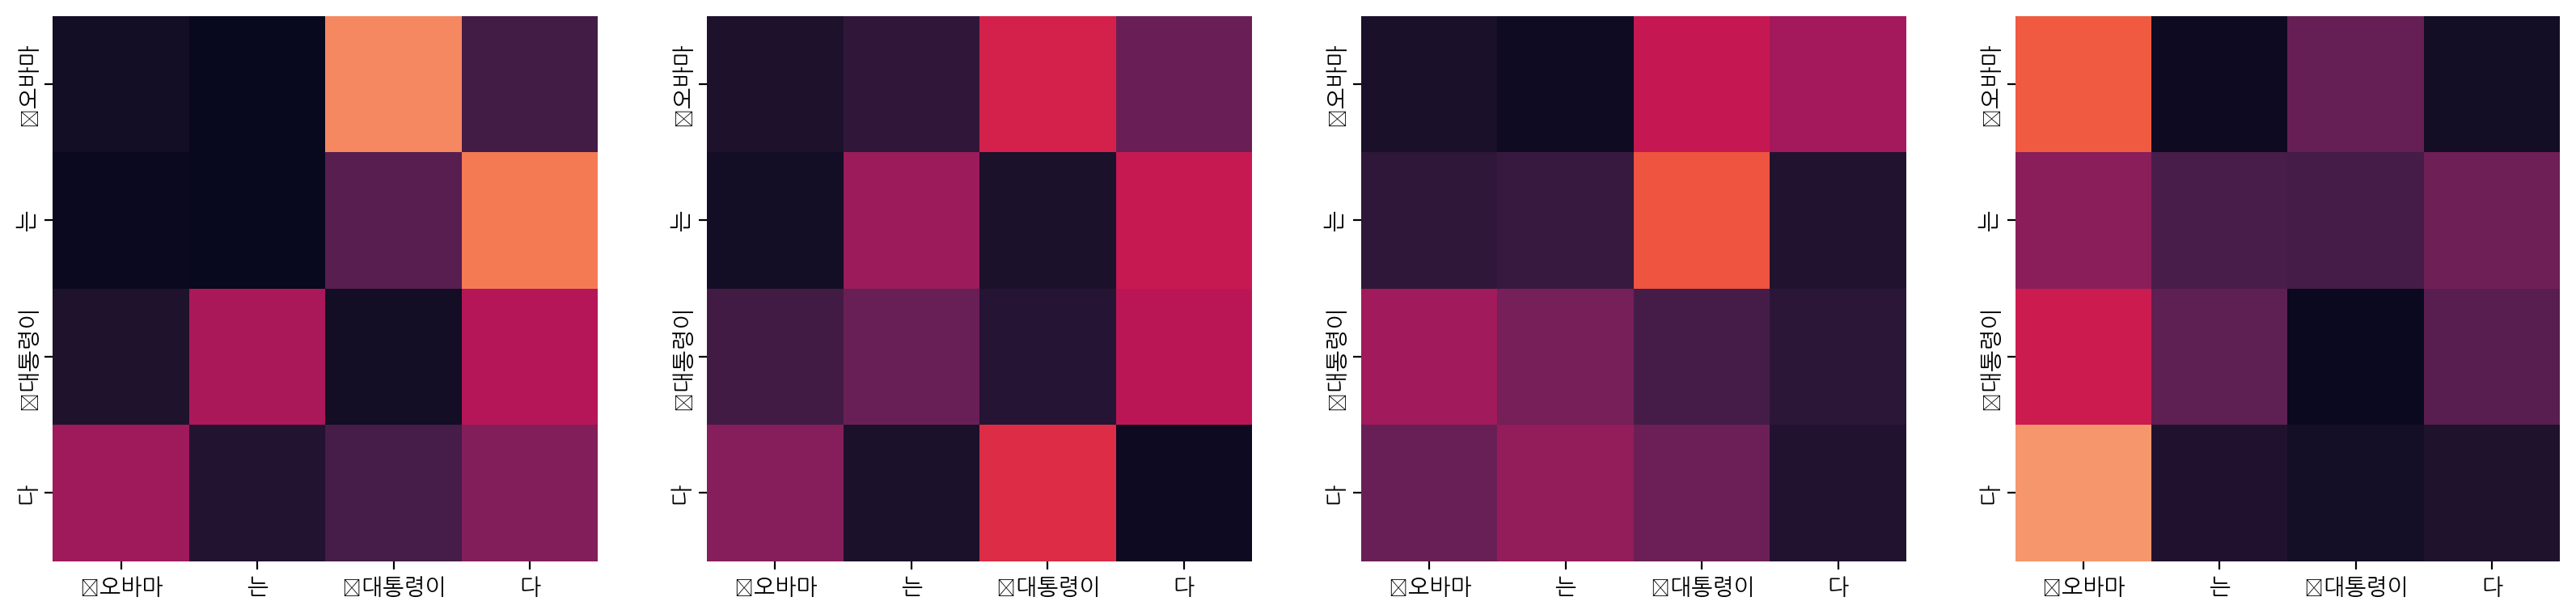

Decoder Self Layer 1


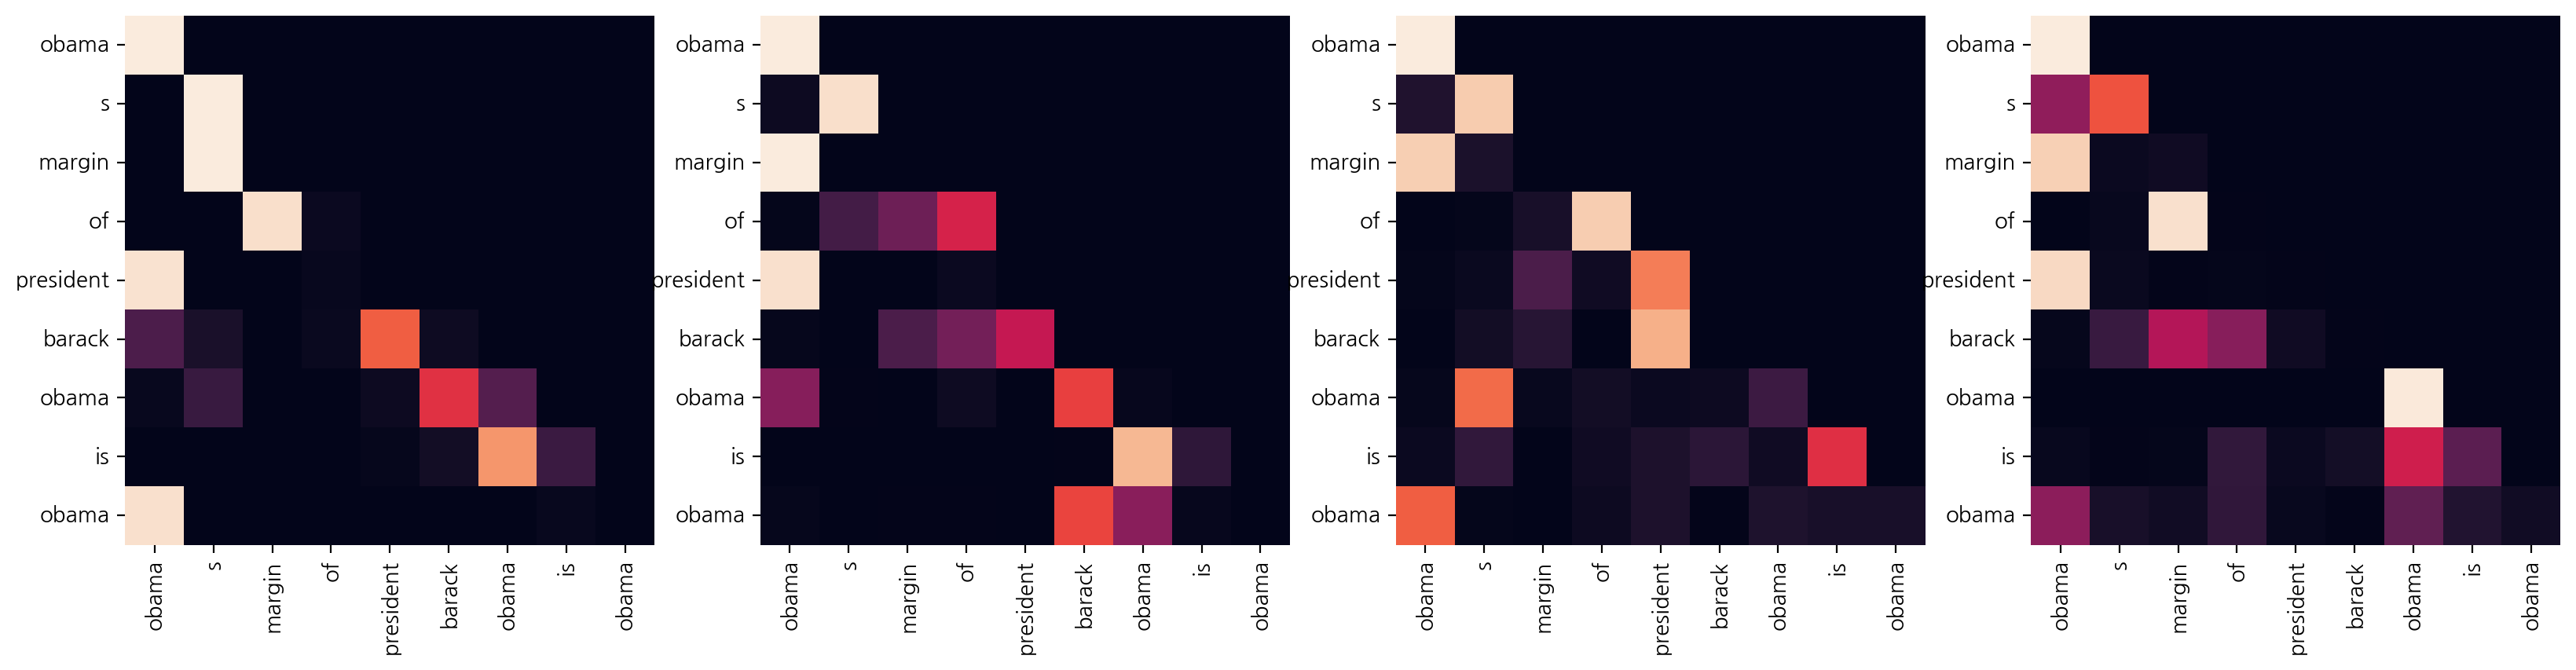

Decoder Src Layer 1


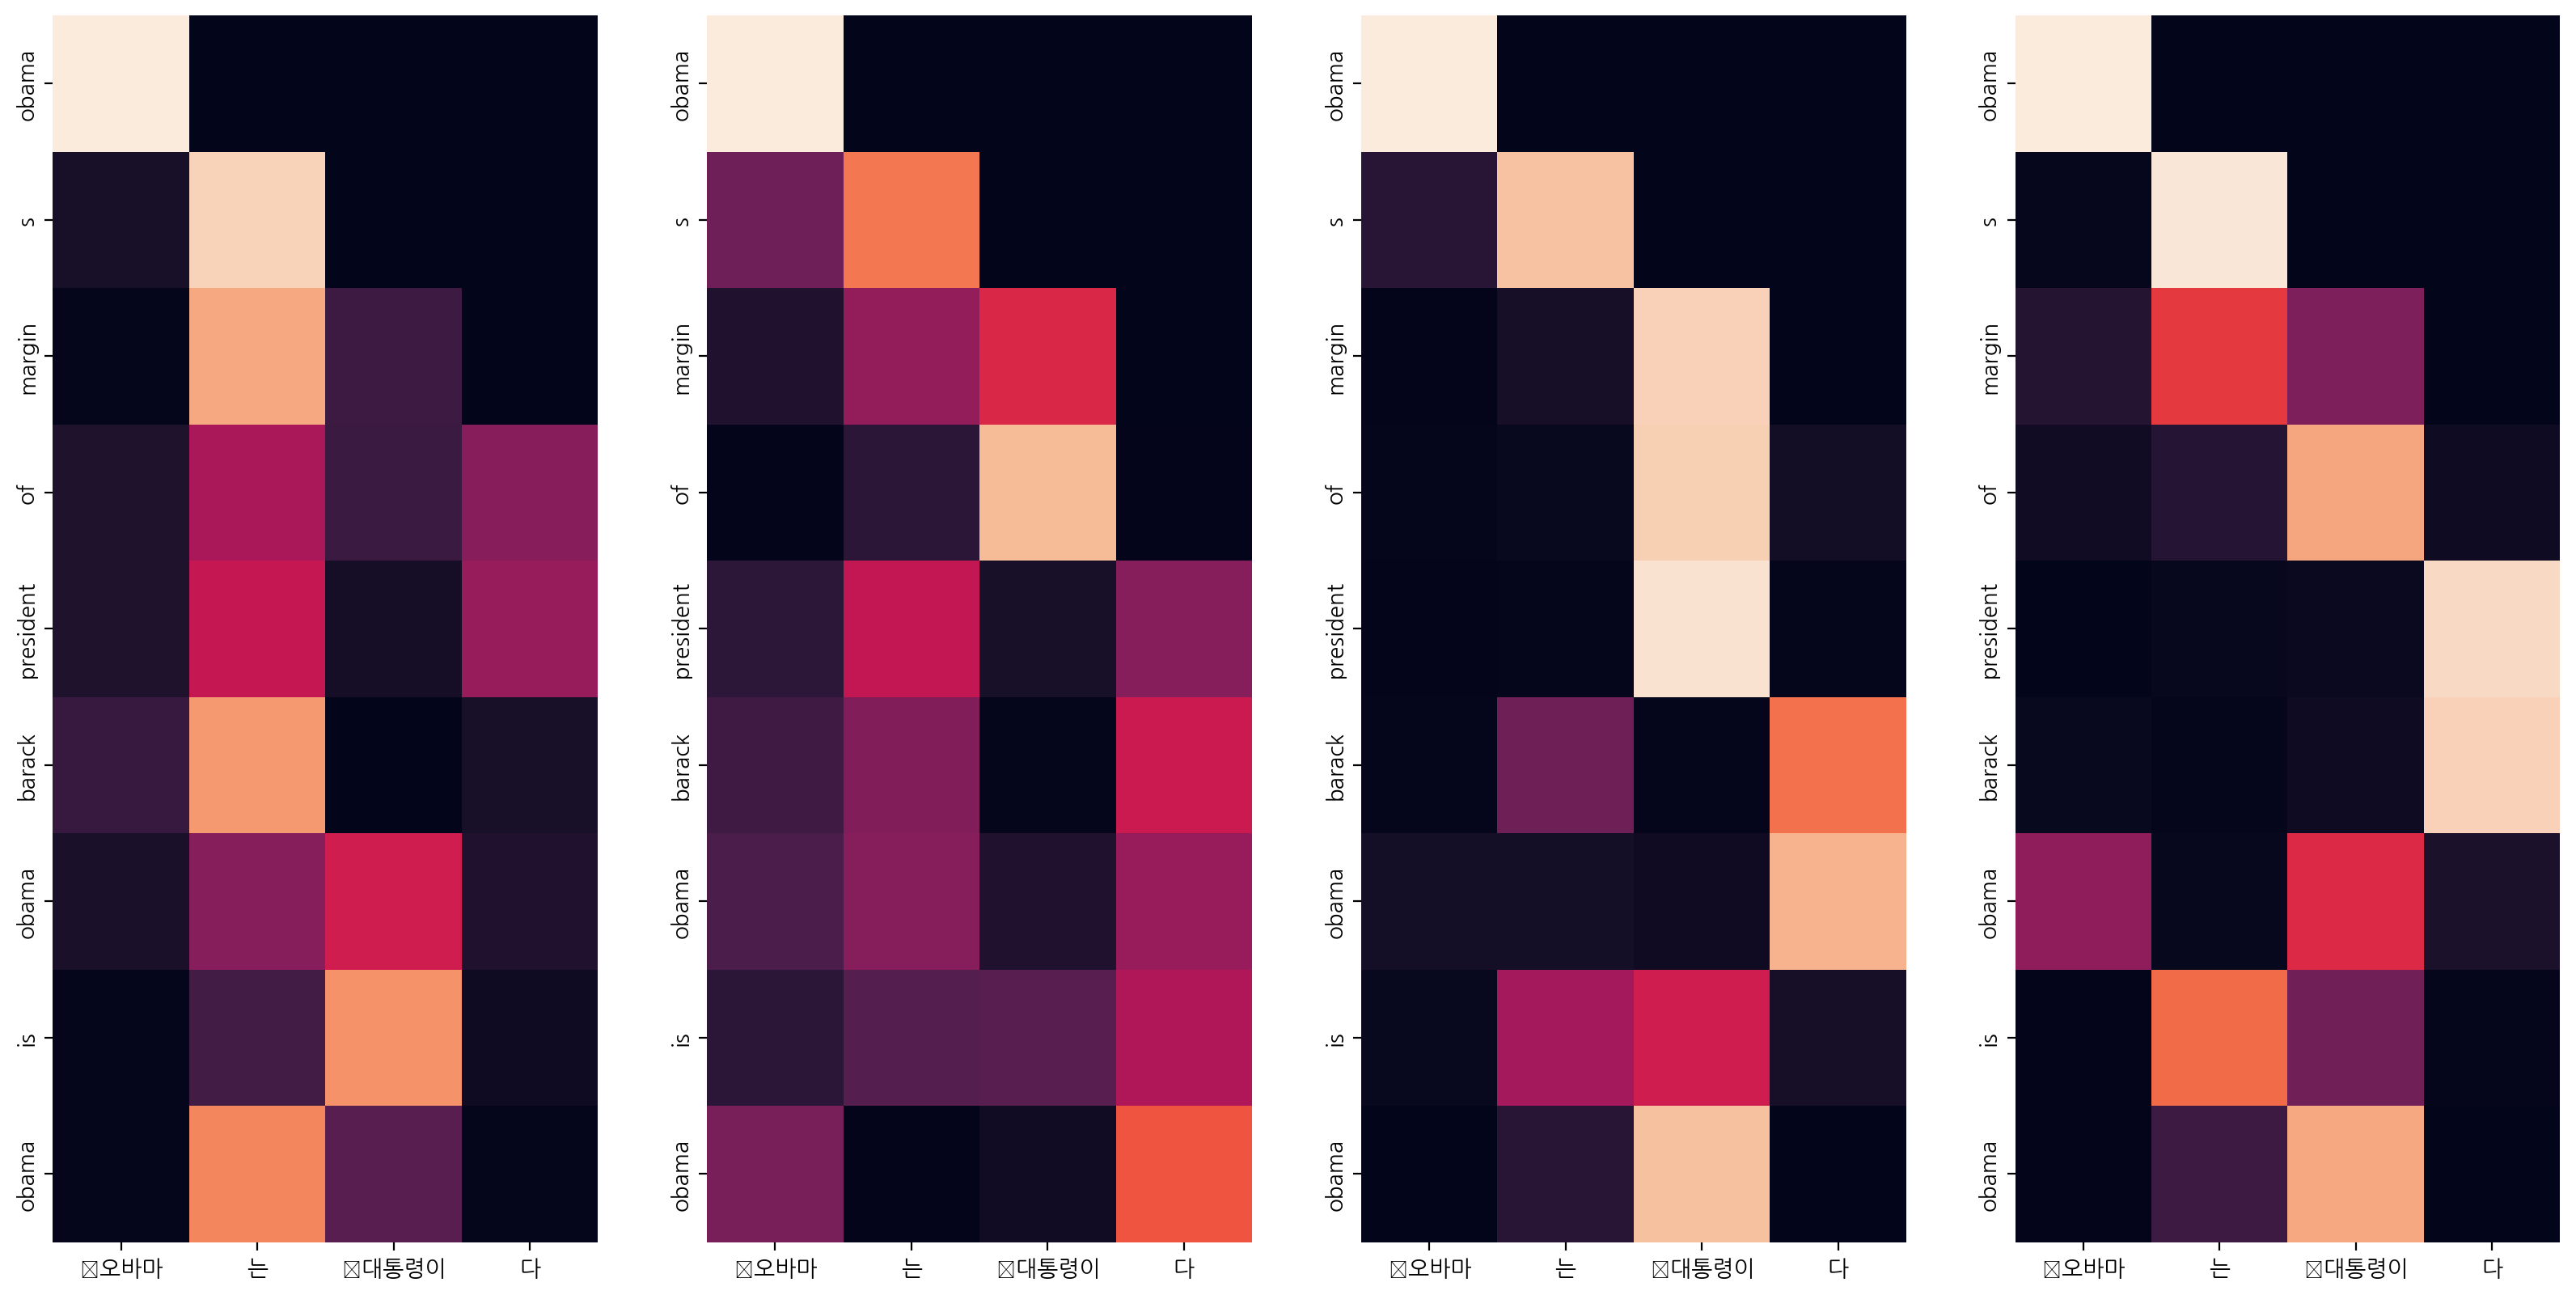

Decoder Self Layer 2


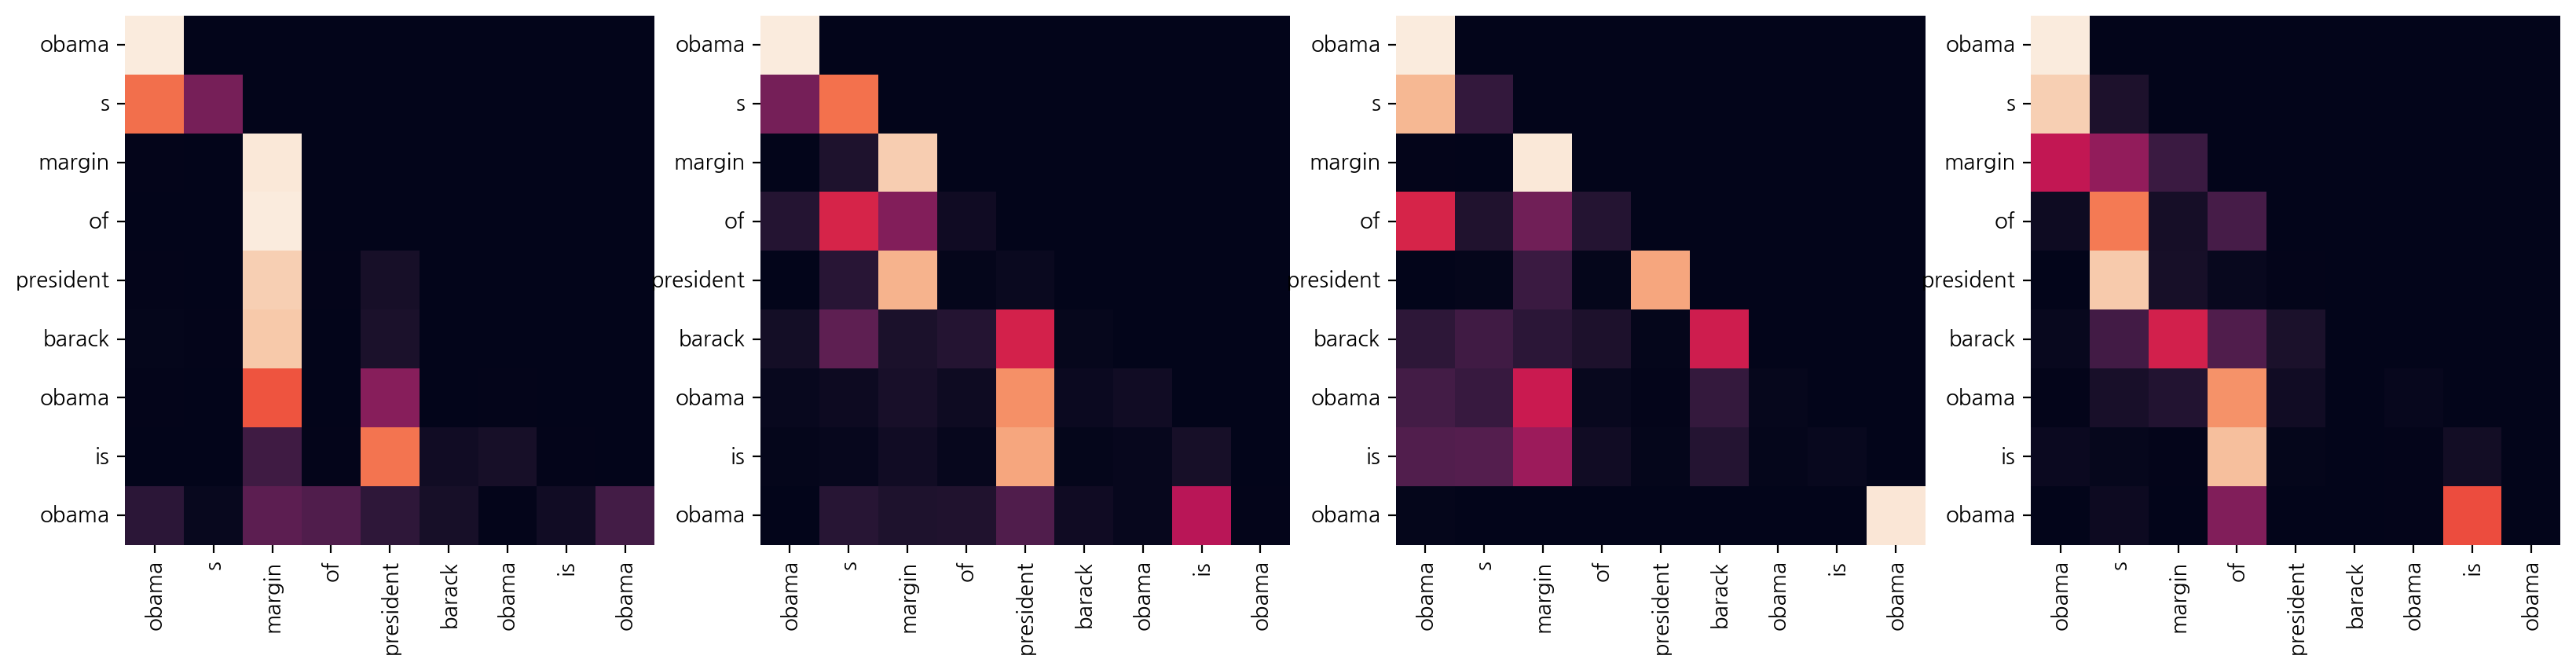

Decoder Src Layer 2


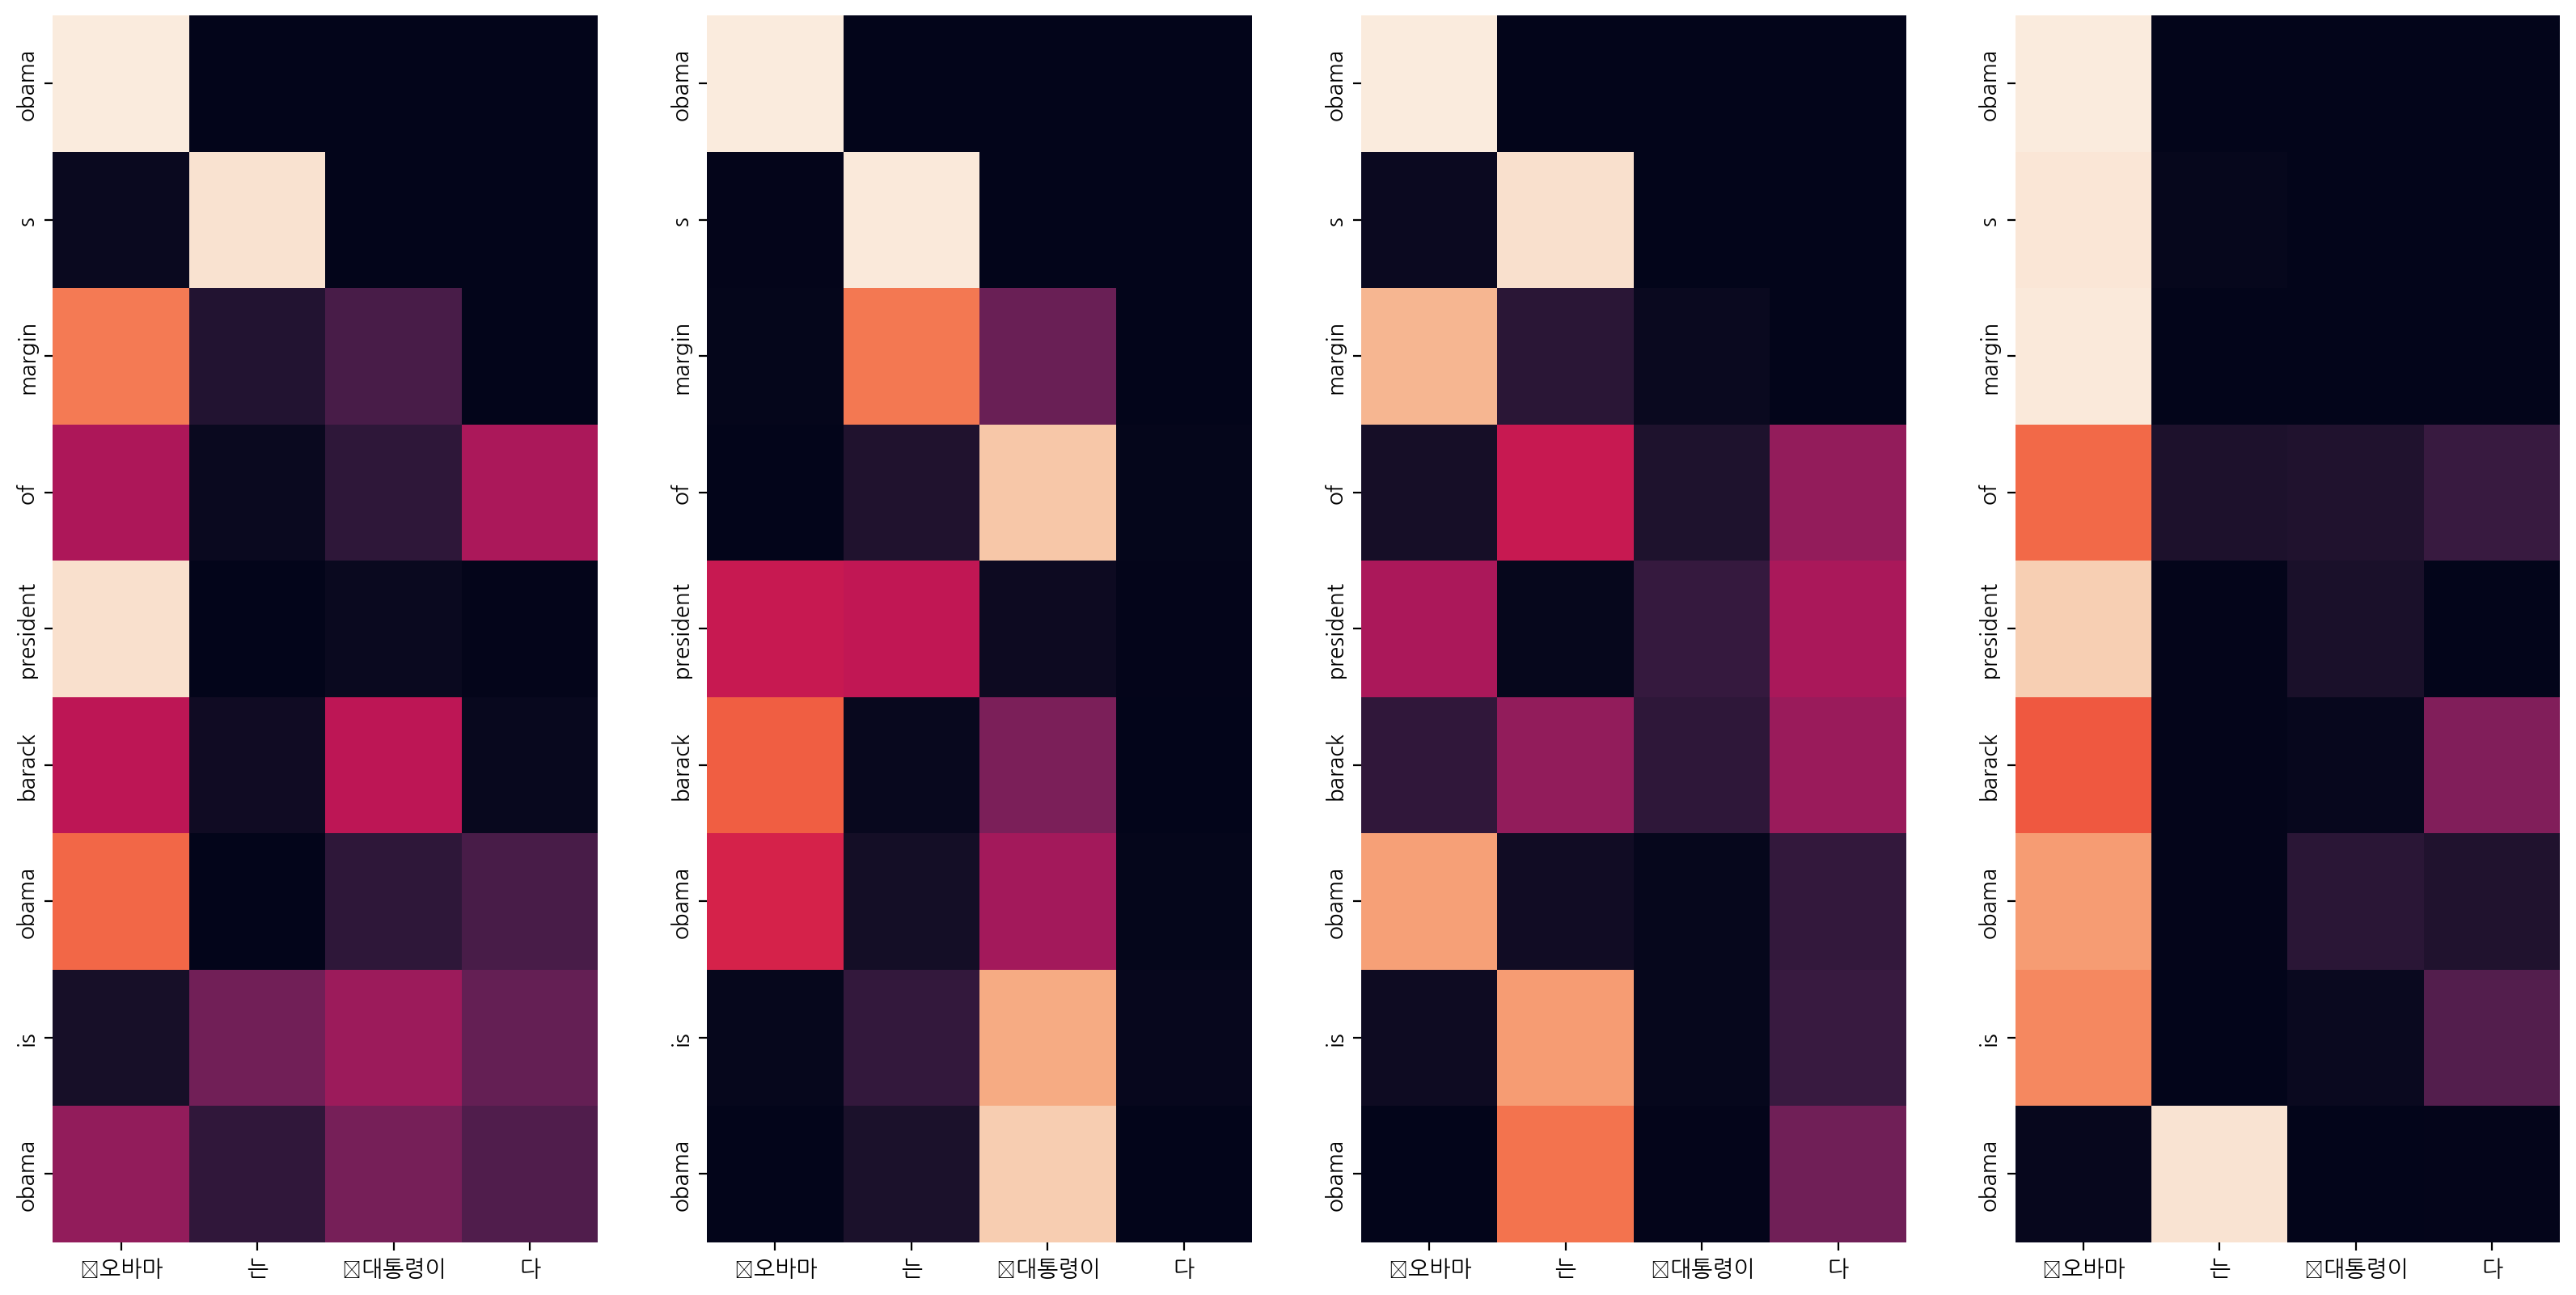

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens live in cities
Encoder Layer 1


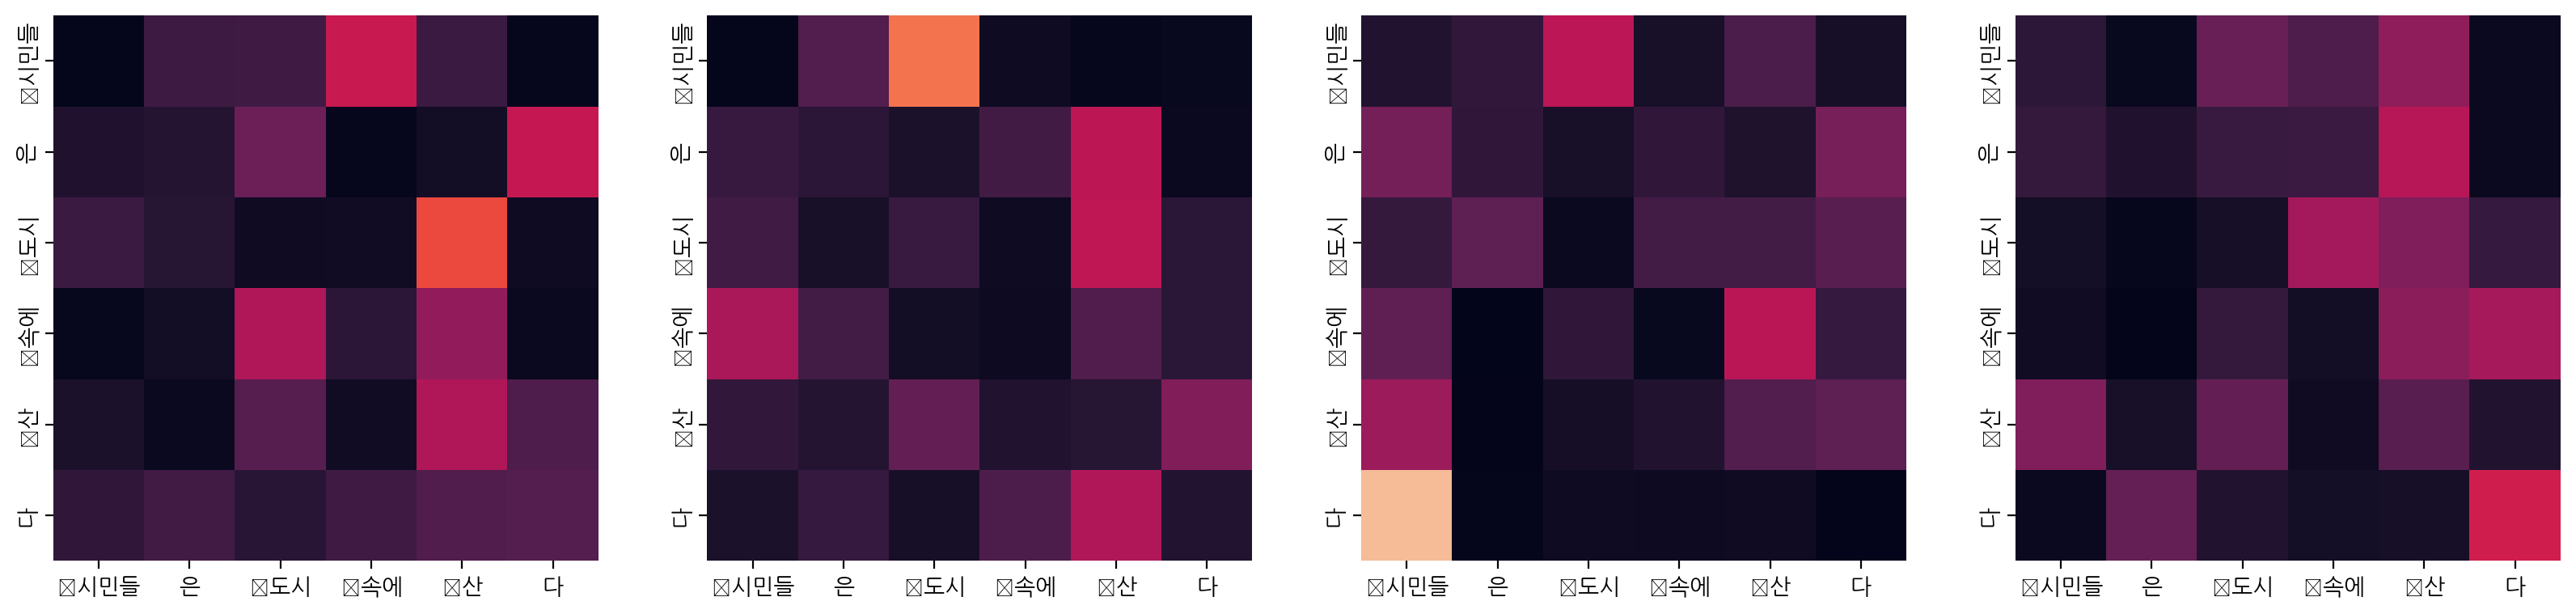

Encoder Layer 2


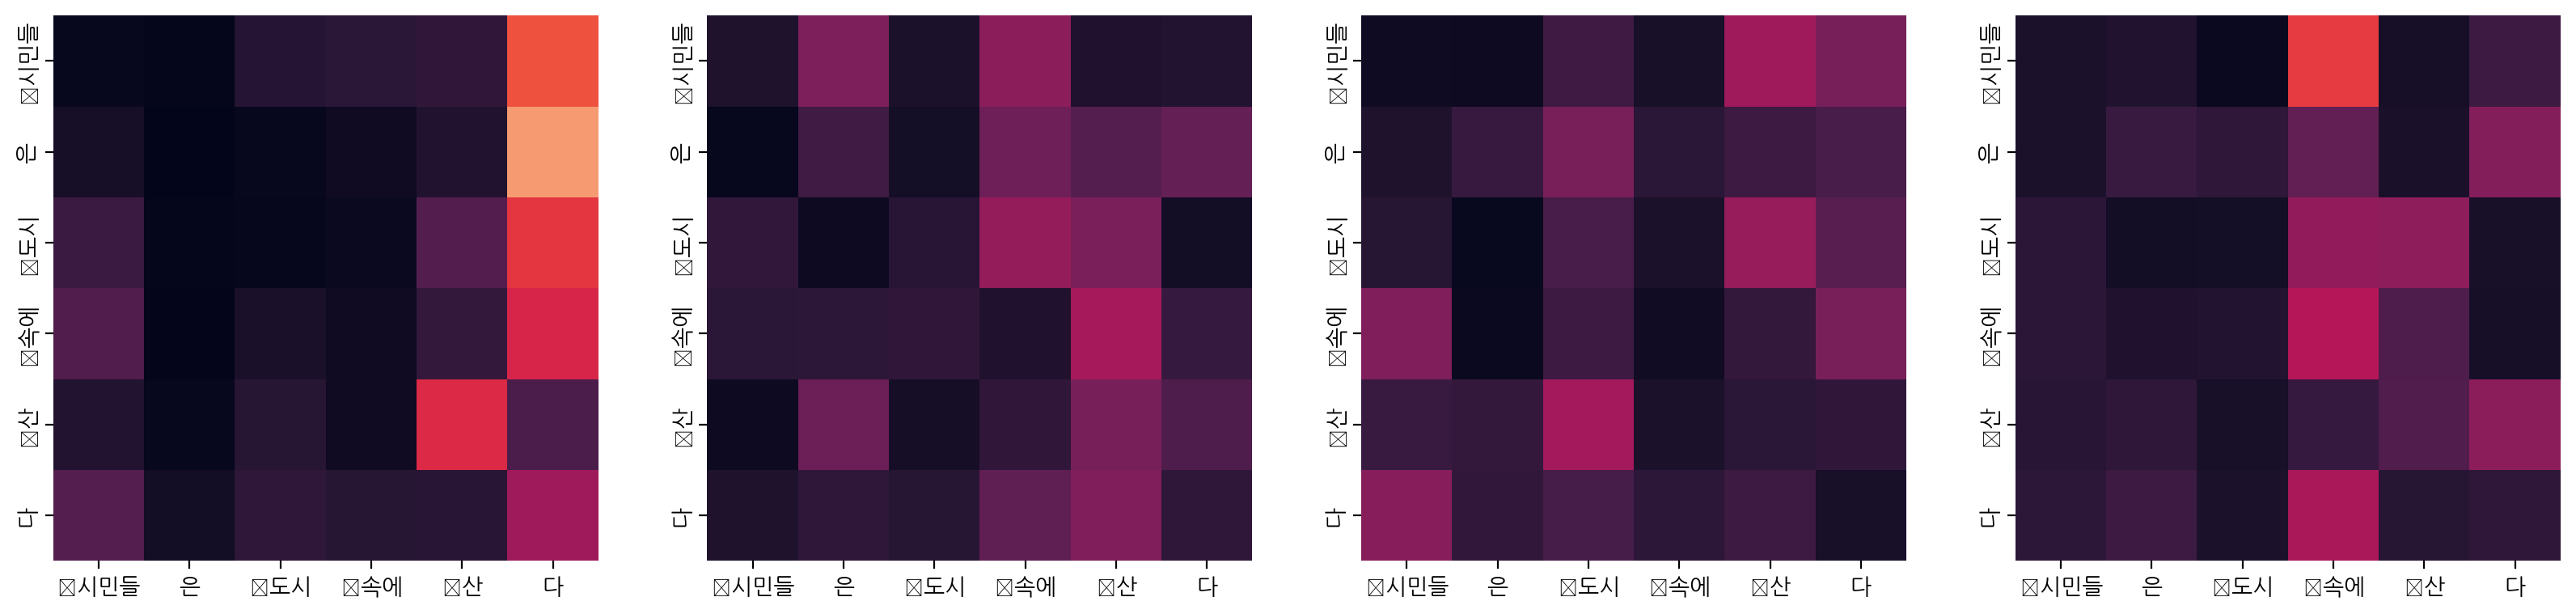

Decoder Self Layer 1


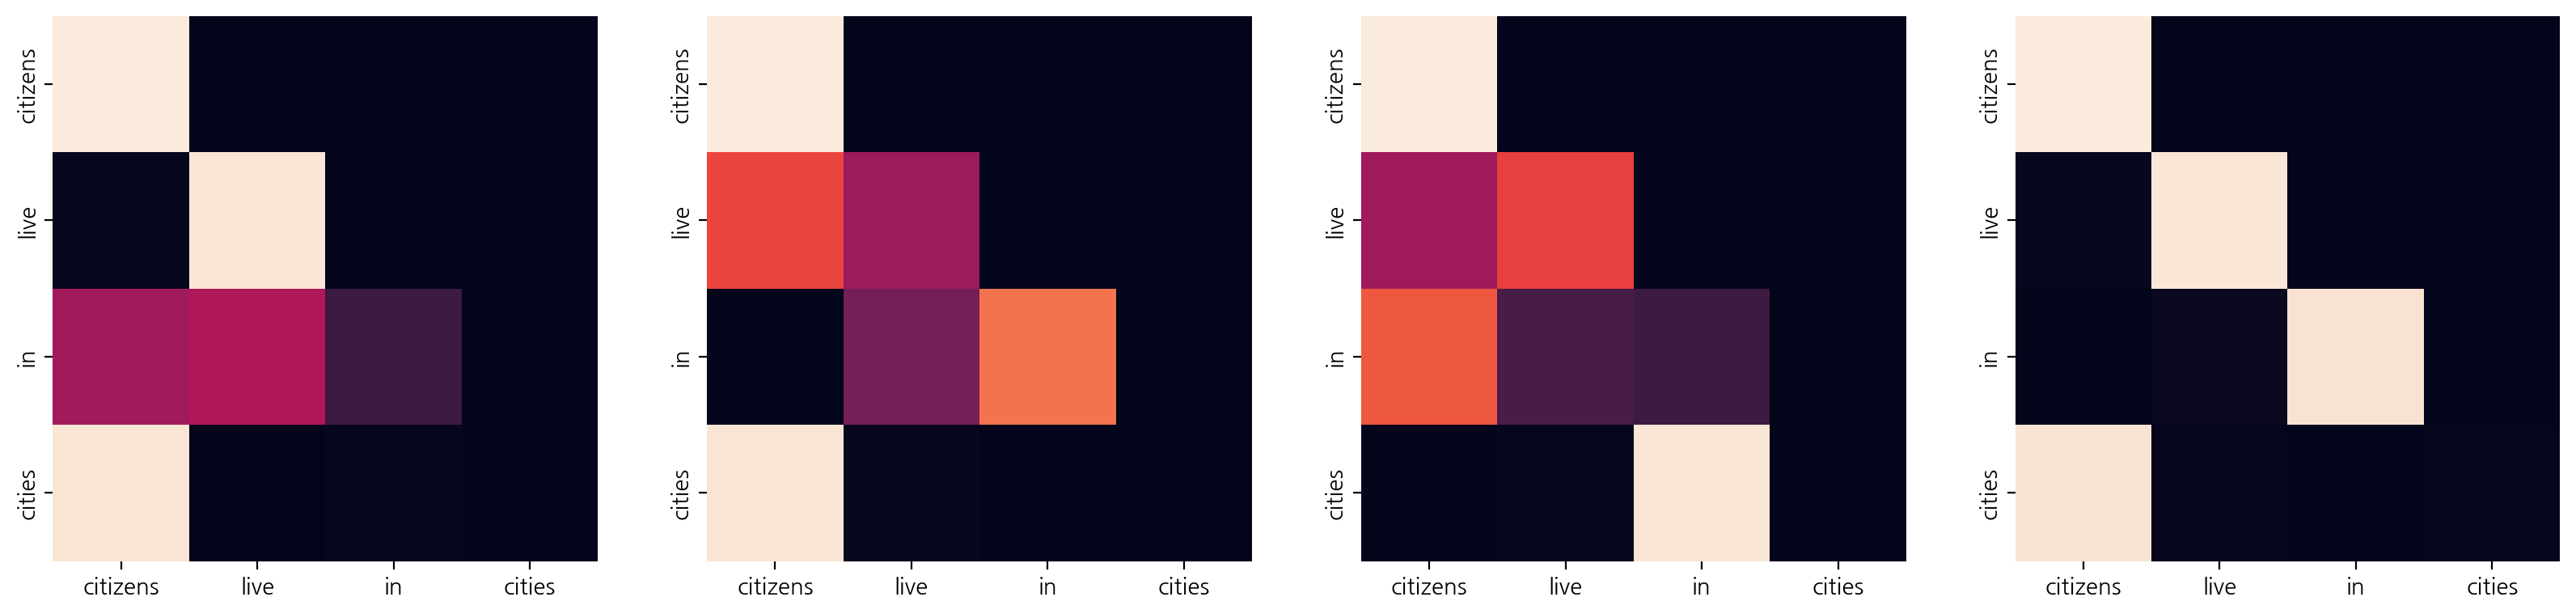

Decoder Src Layer 1


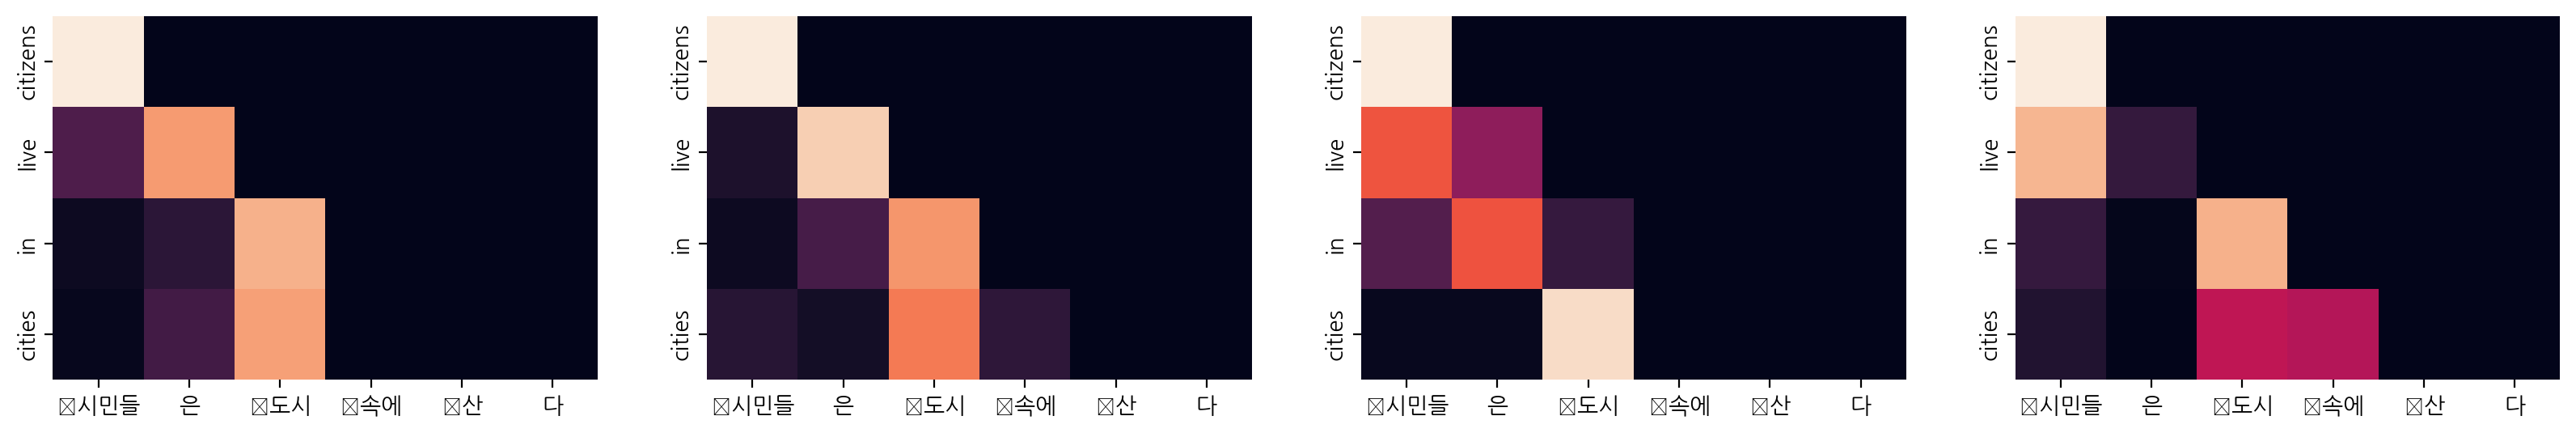

Decoder Self Layer 2


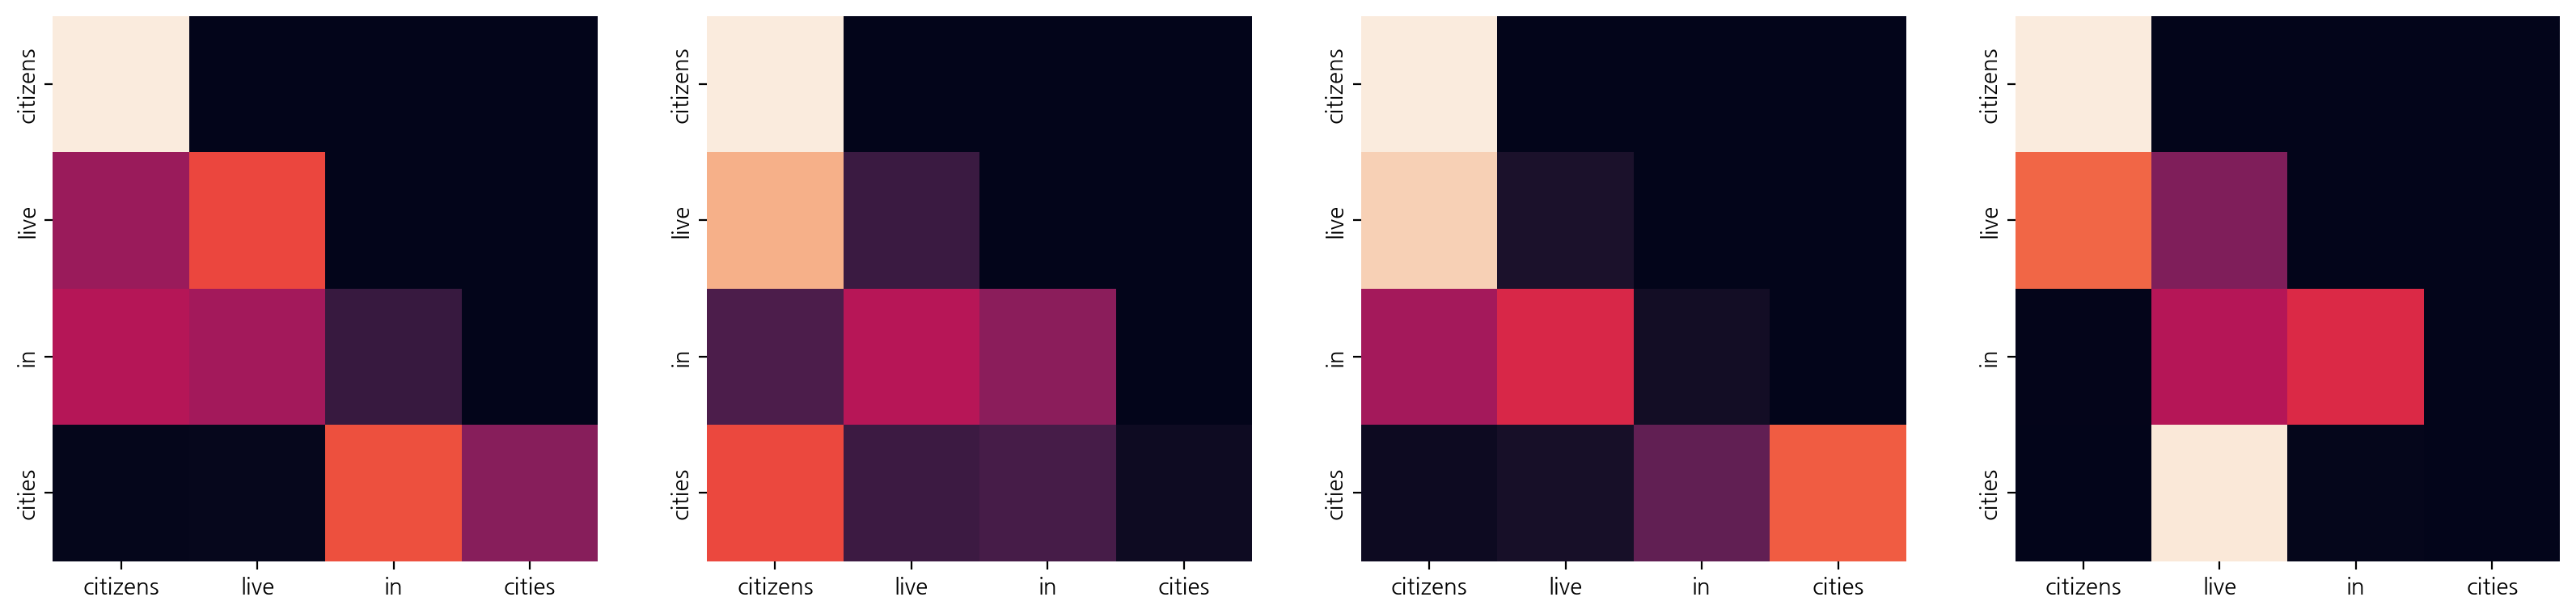

Decoder Src Layer 2


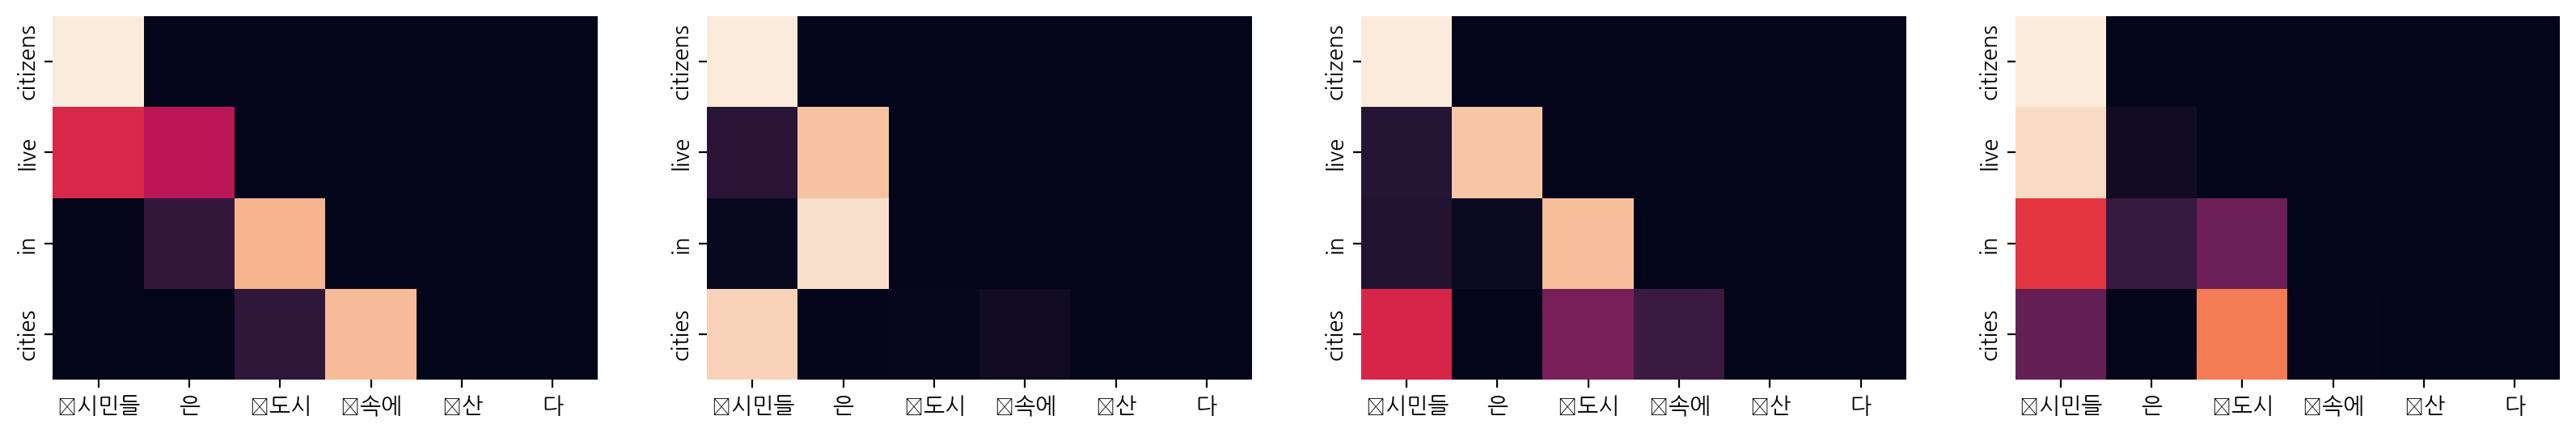

Input: 커피는 필요 없다.
Predicted translation: coffee shops don t need coffee
Encoder Layer 1


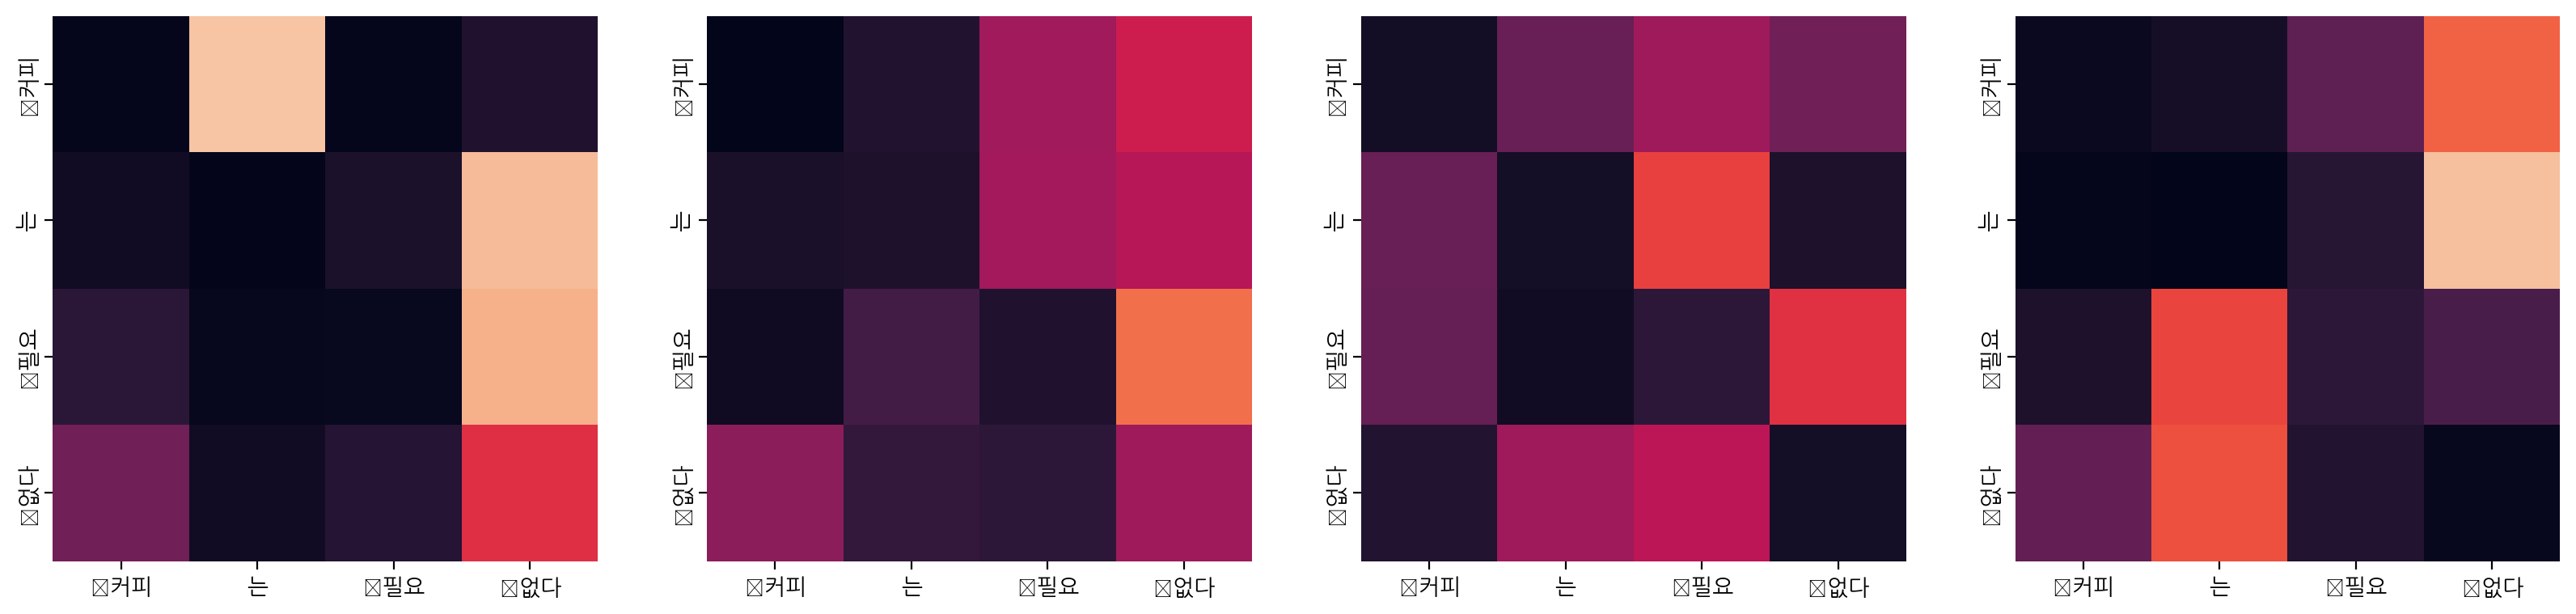

Encoder Layer 2


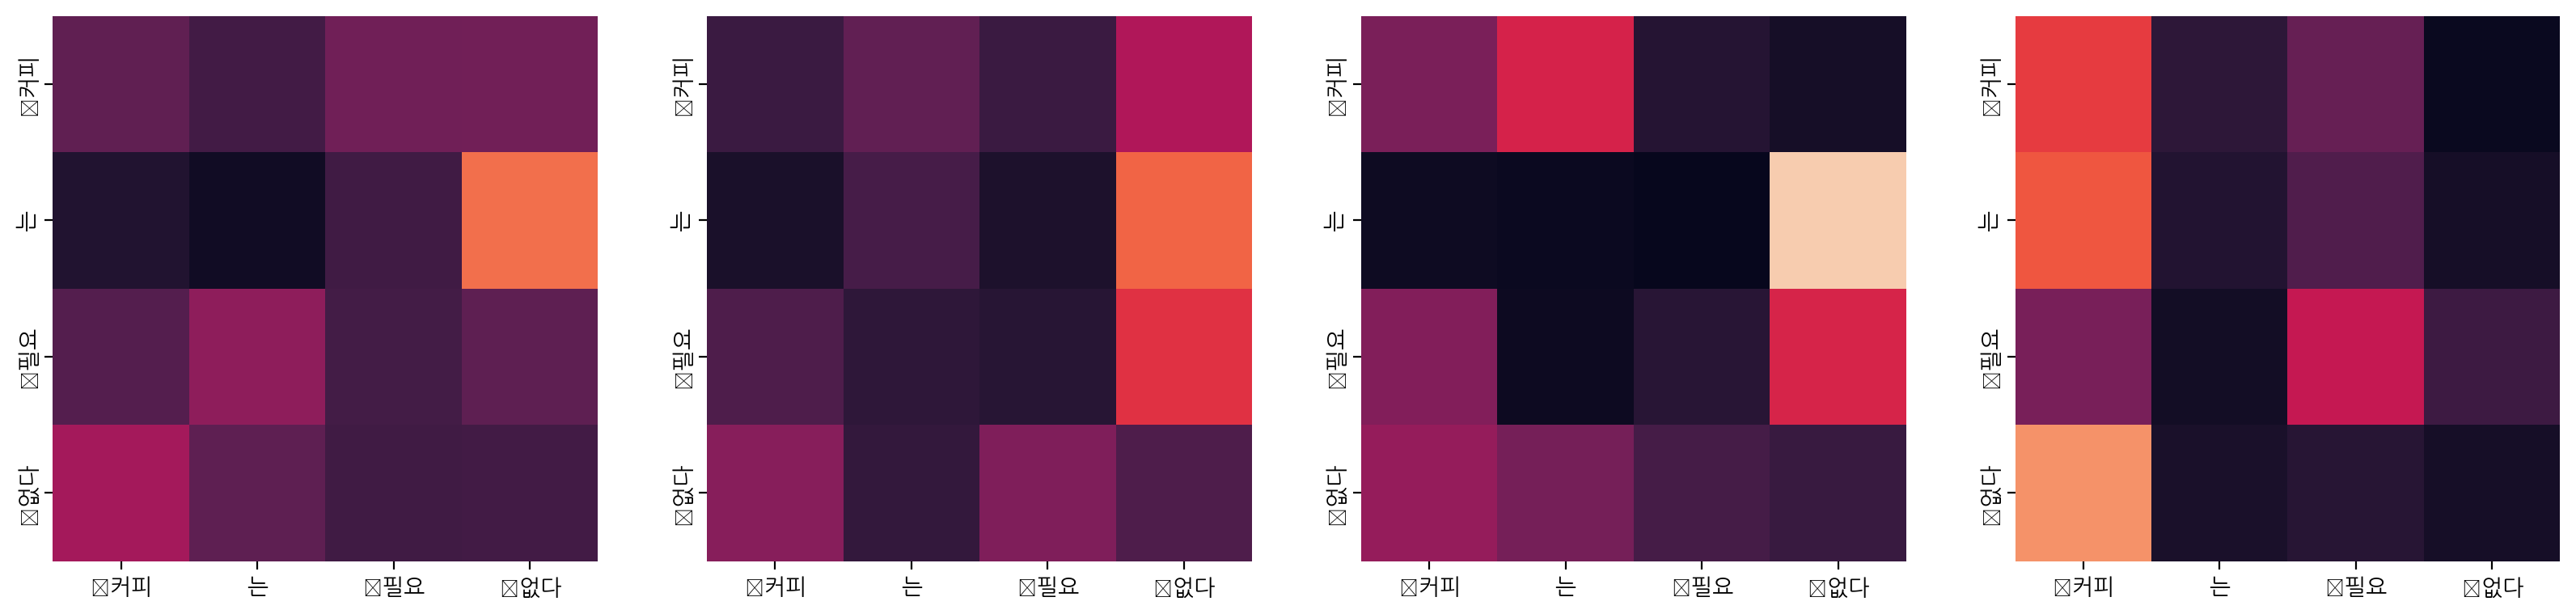

Decoder Self Layer 1


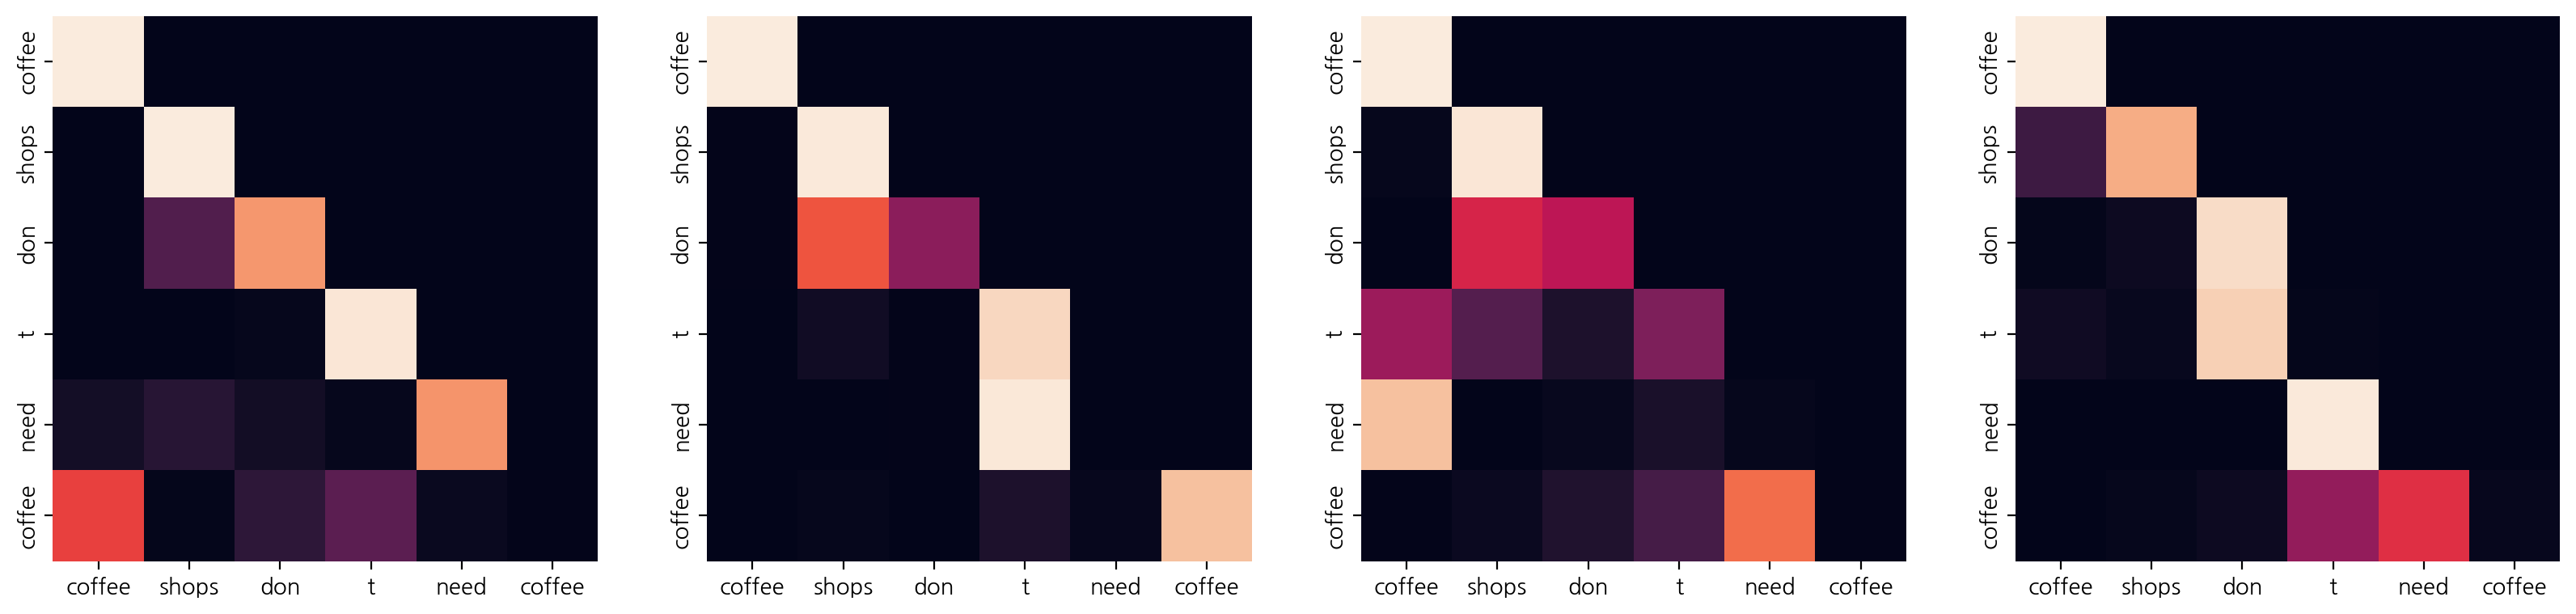

Decoder Src Layer 1


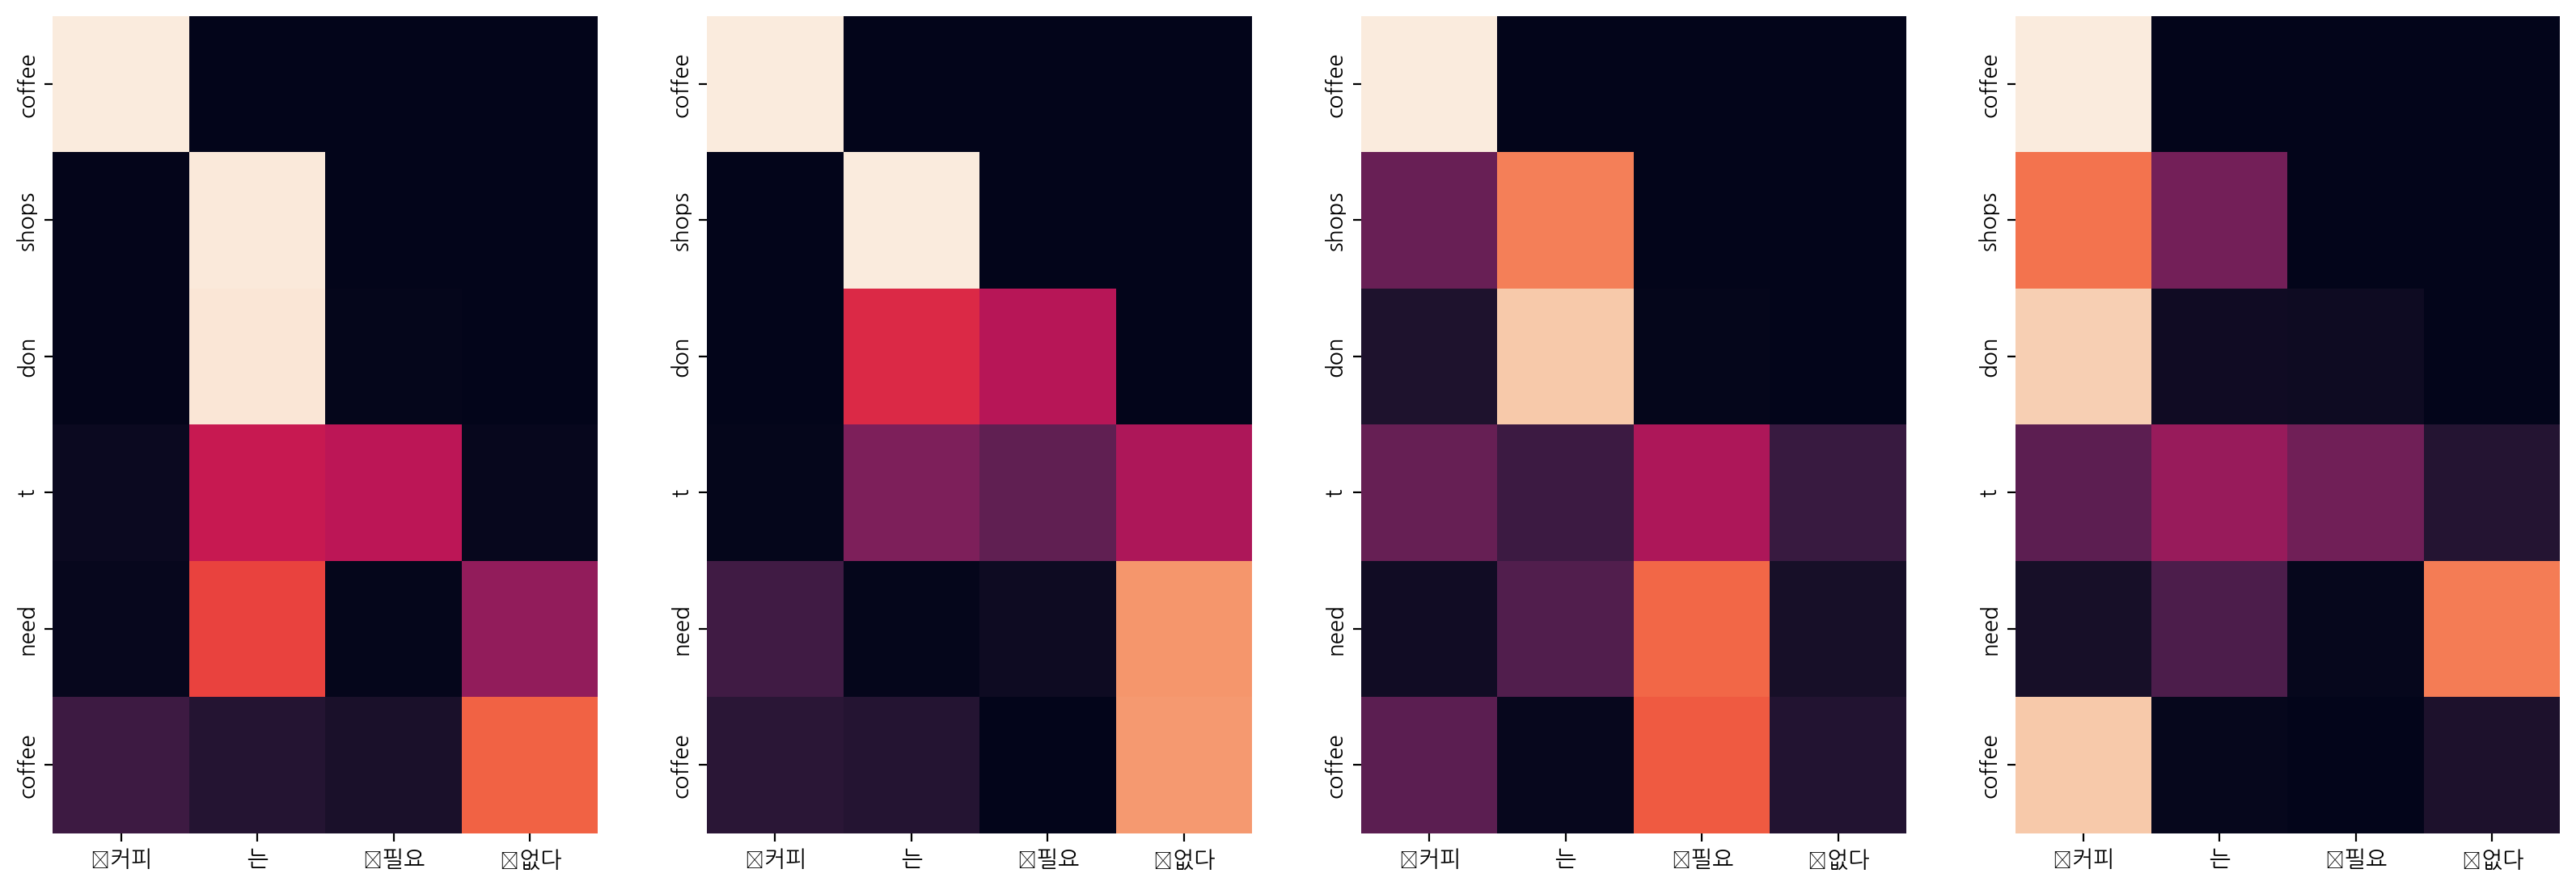

Decoder Self Layer 2


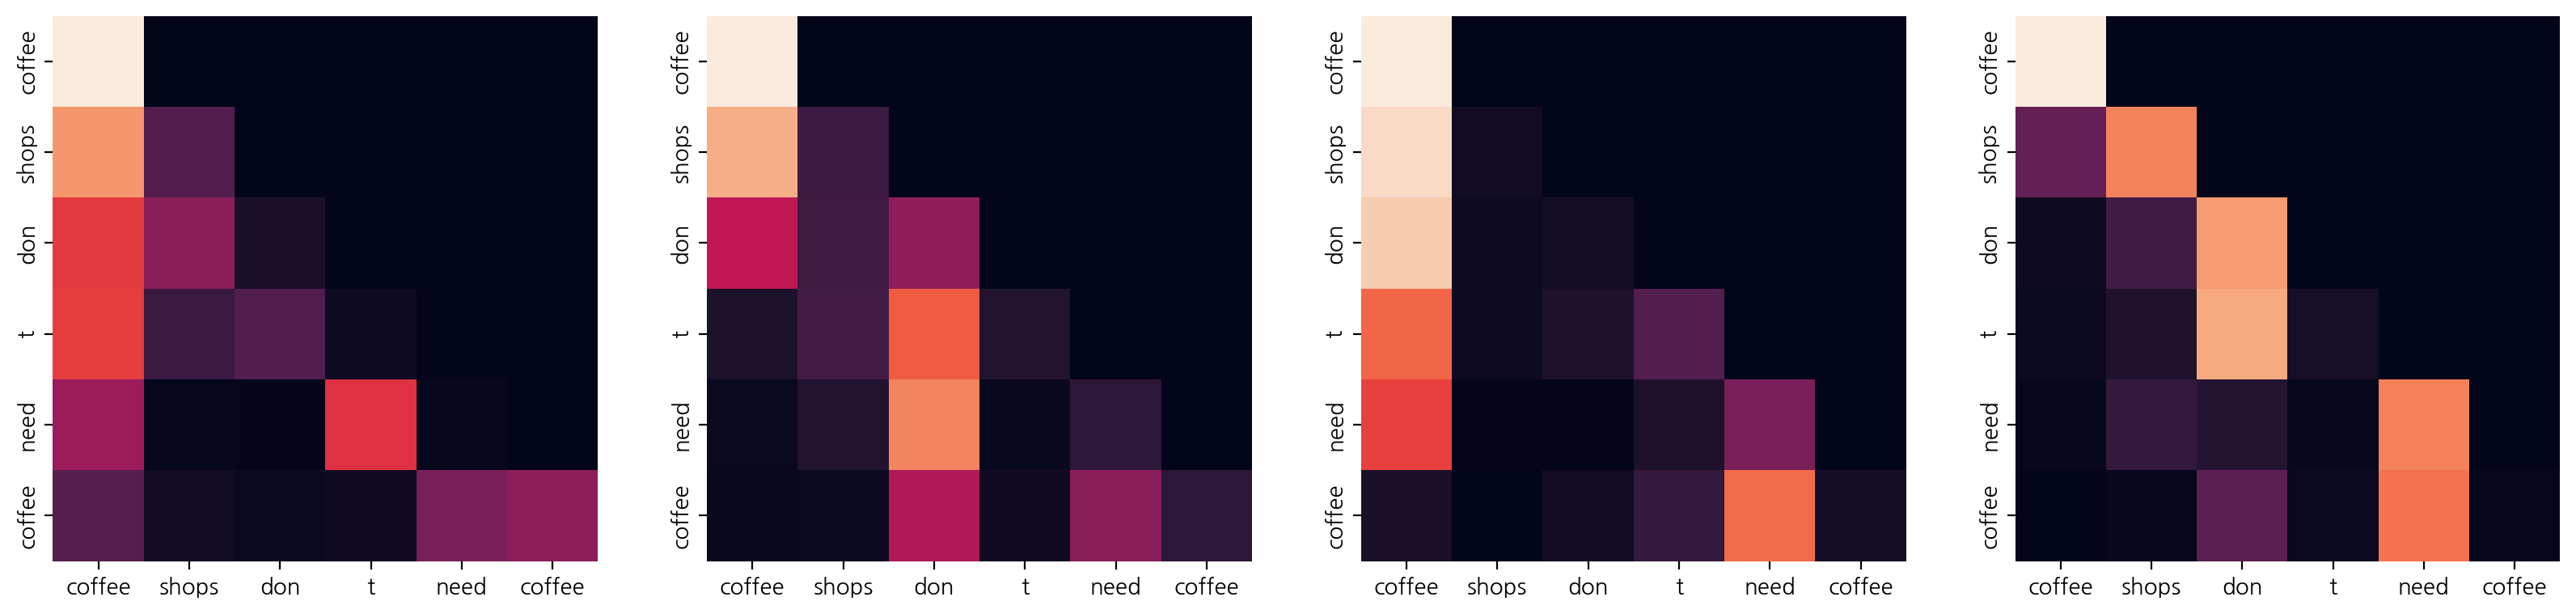

Decoder Src Layer 2


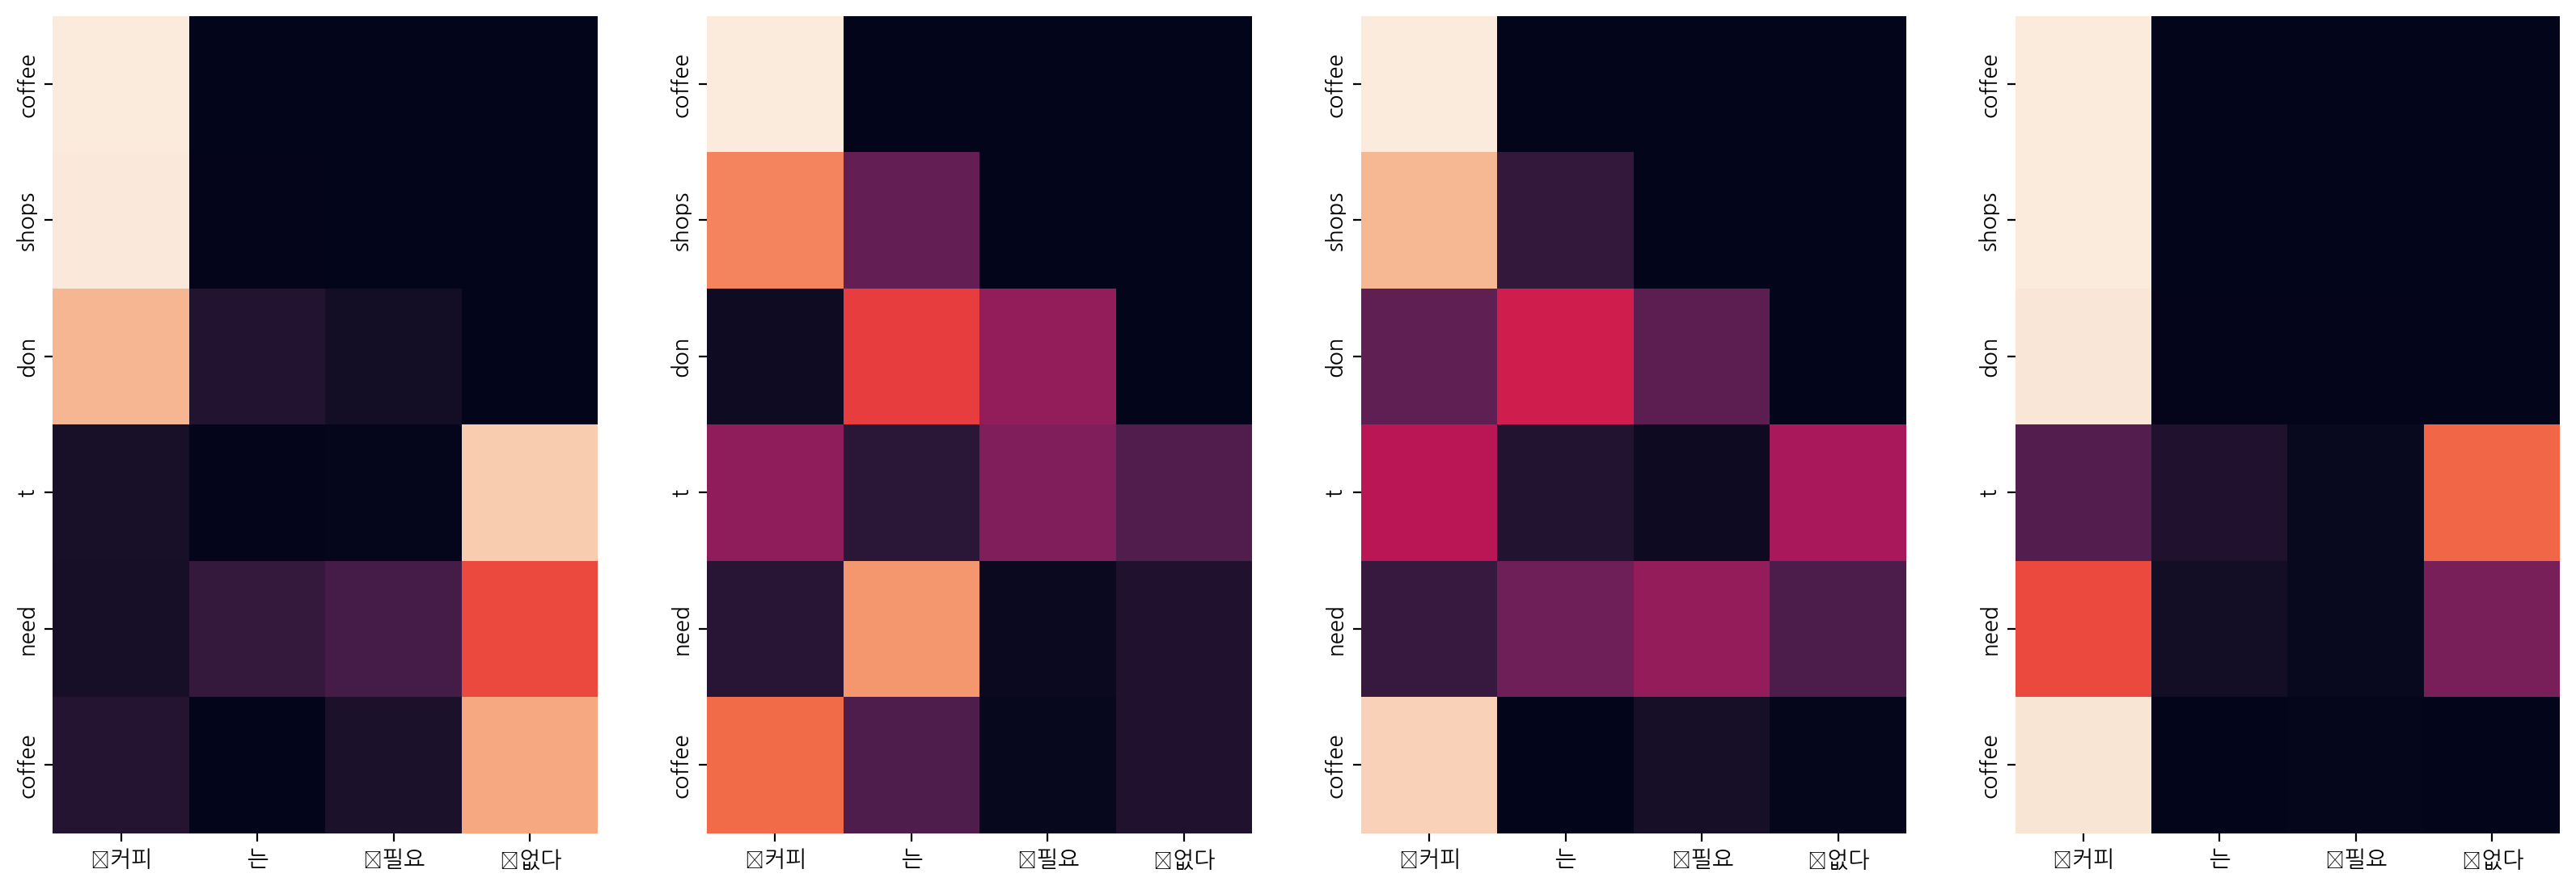

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a total of seven people were killed
Encoder Layer 1


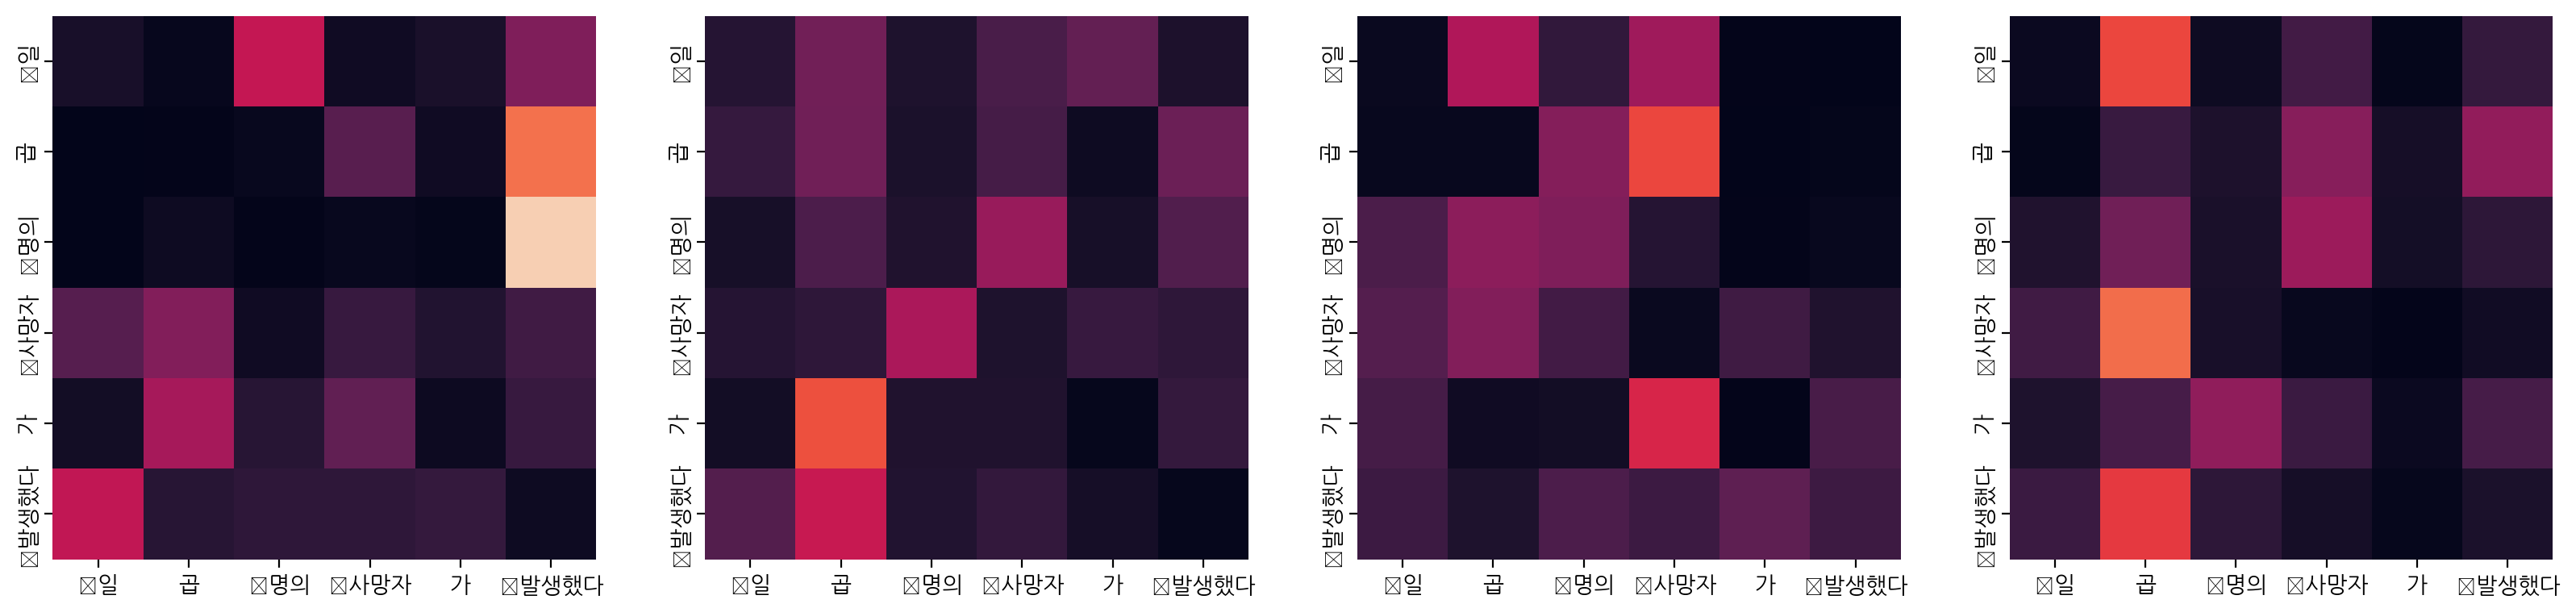

Encoder Layer 2


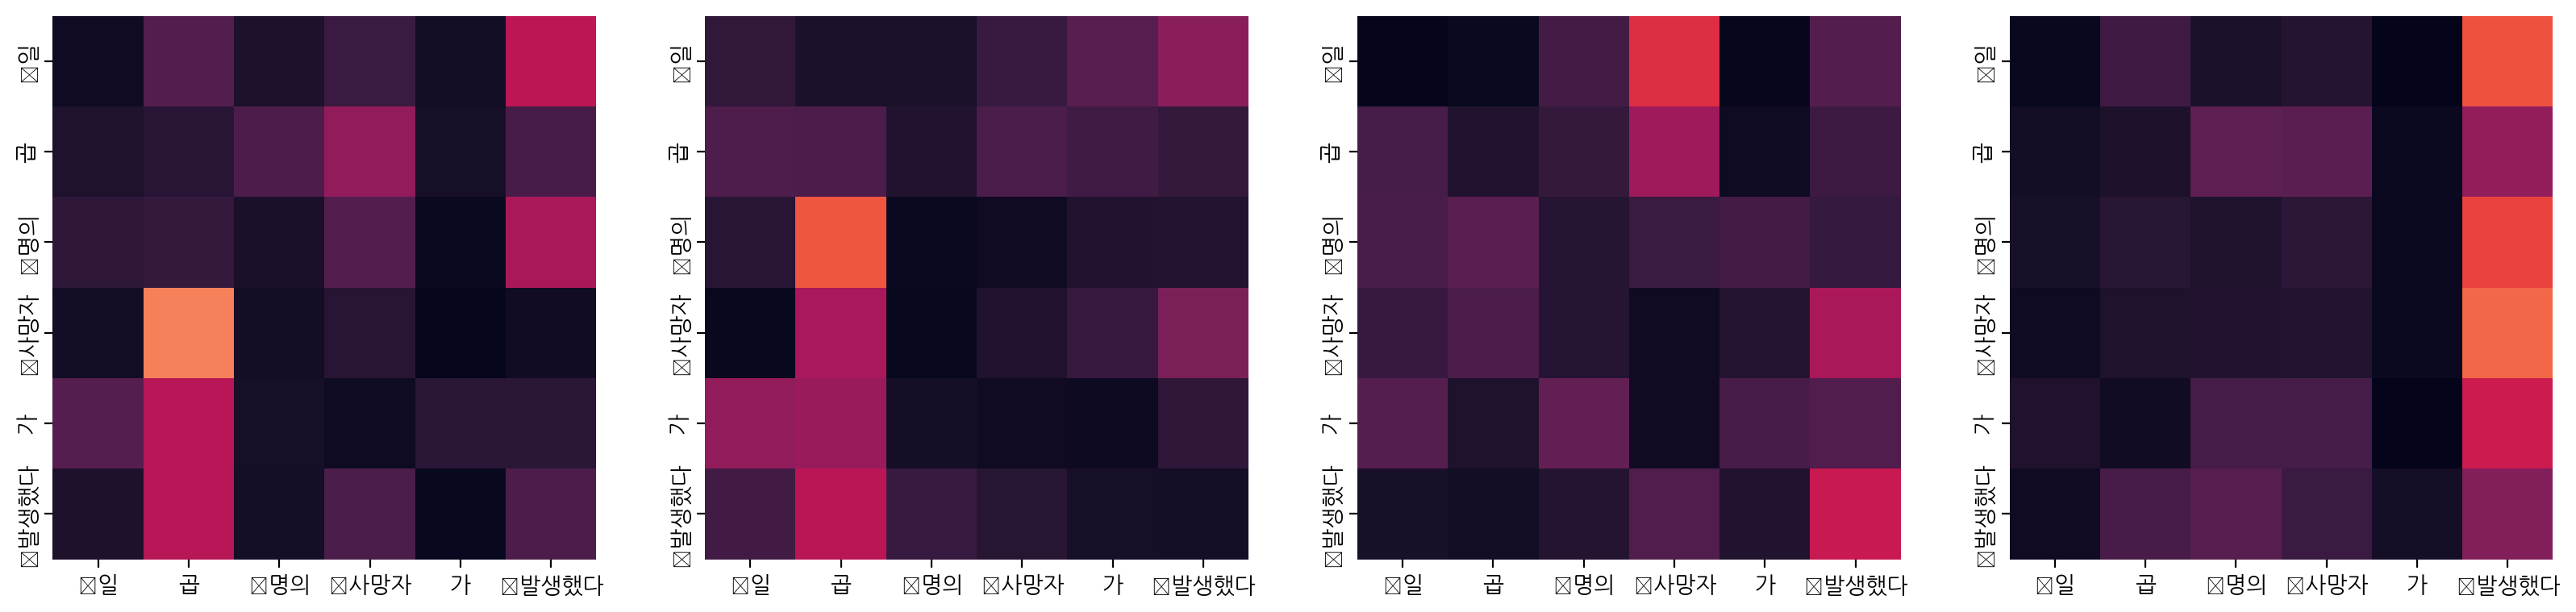

Decoder Self Layer 1


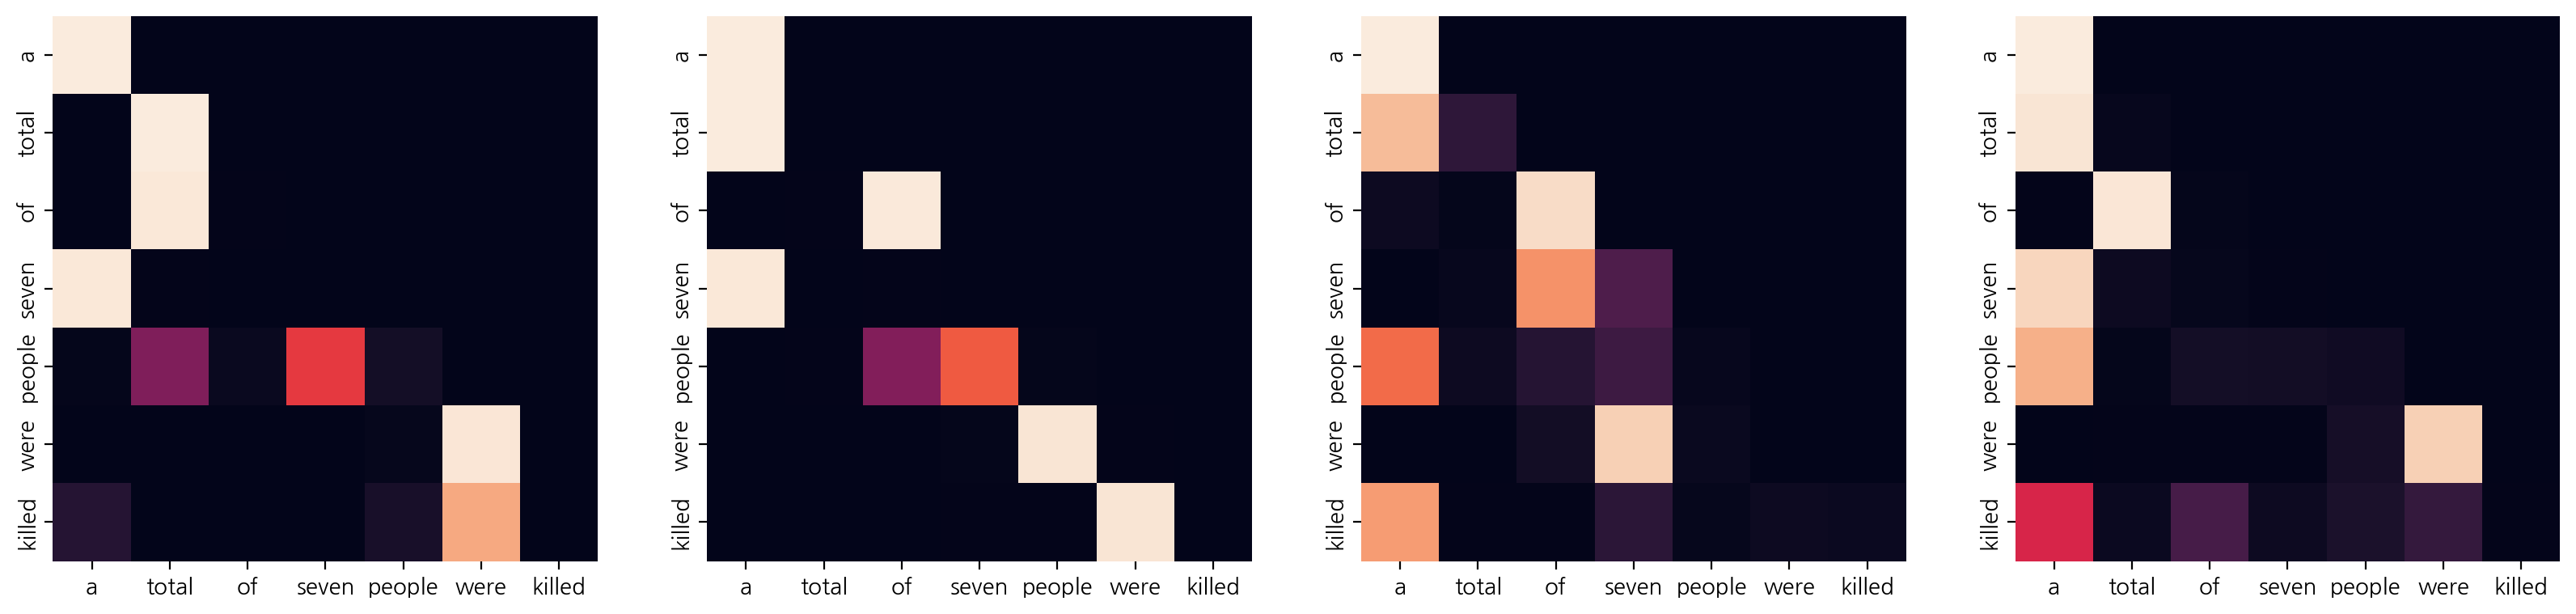

Decoder Src Layer 1


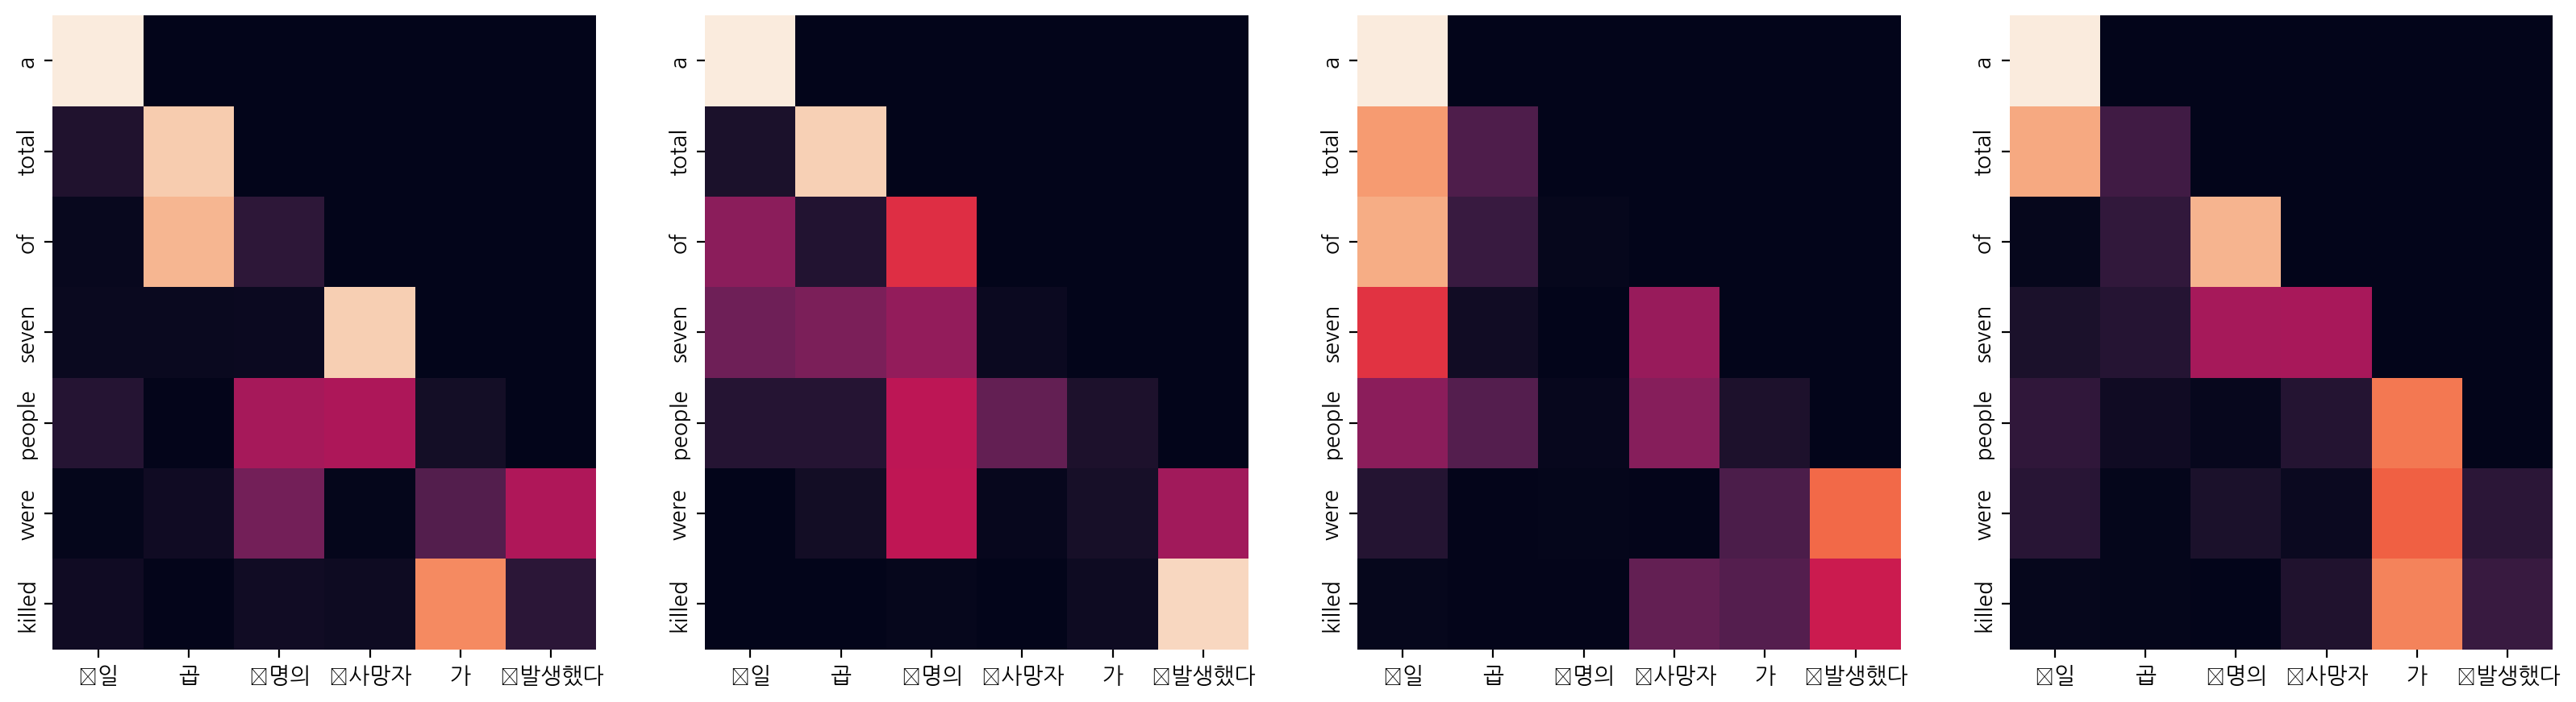

Decoder Self Layer 2


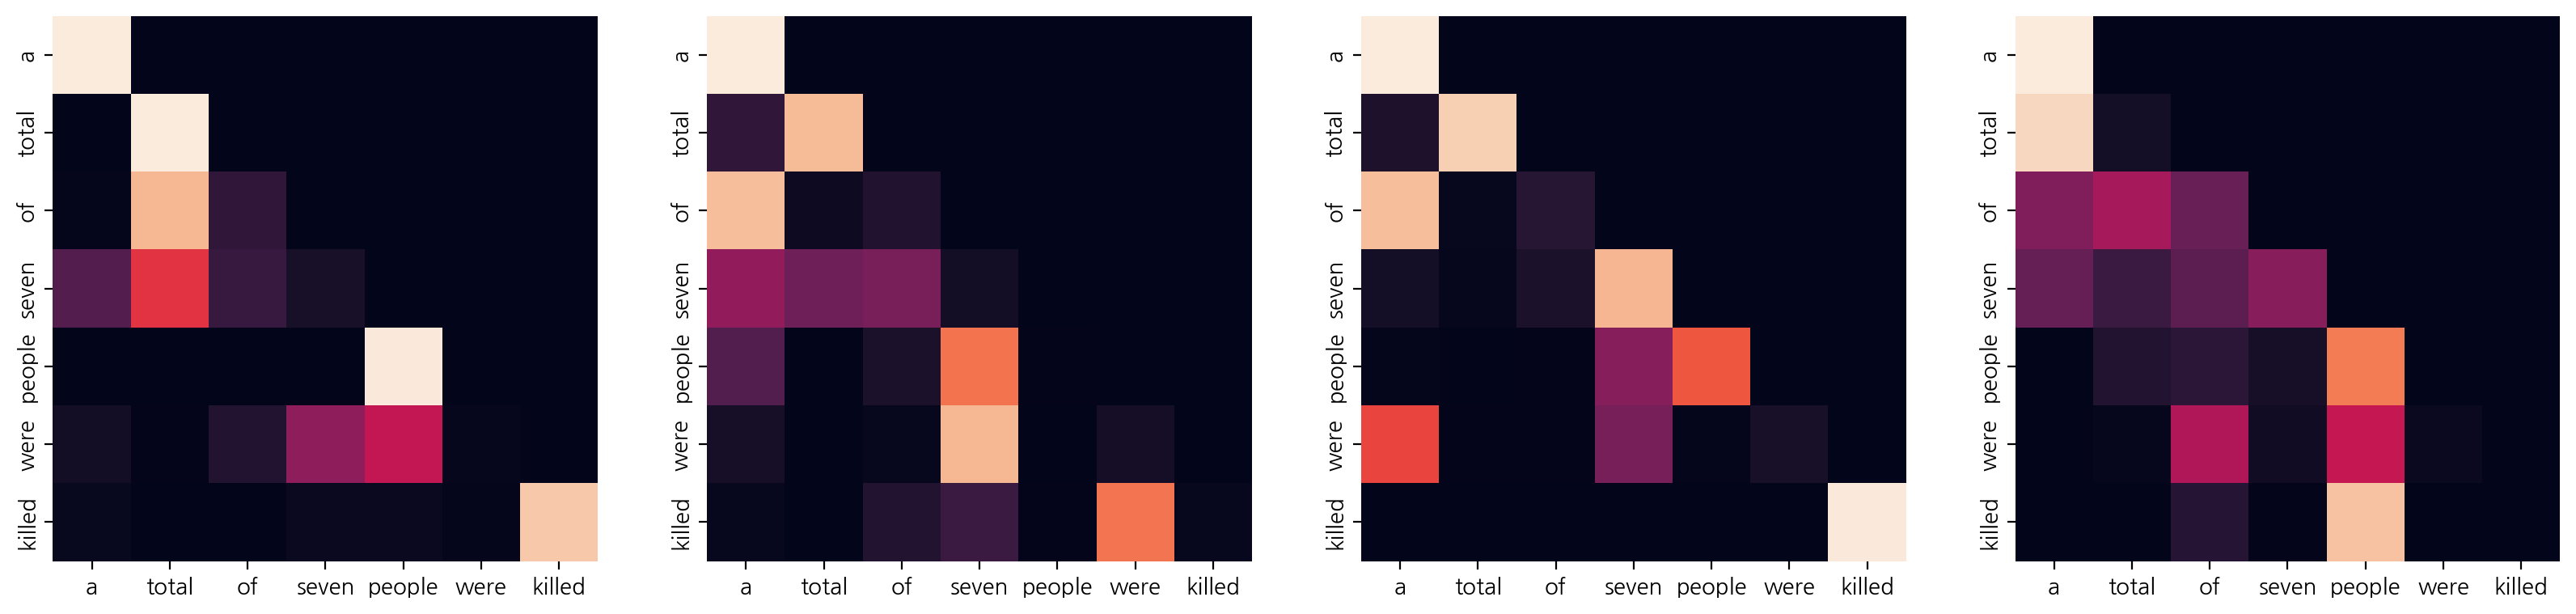

Decoder Src Layer 2


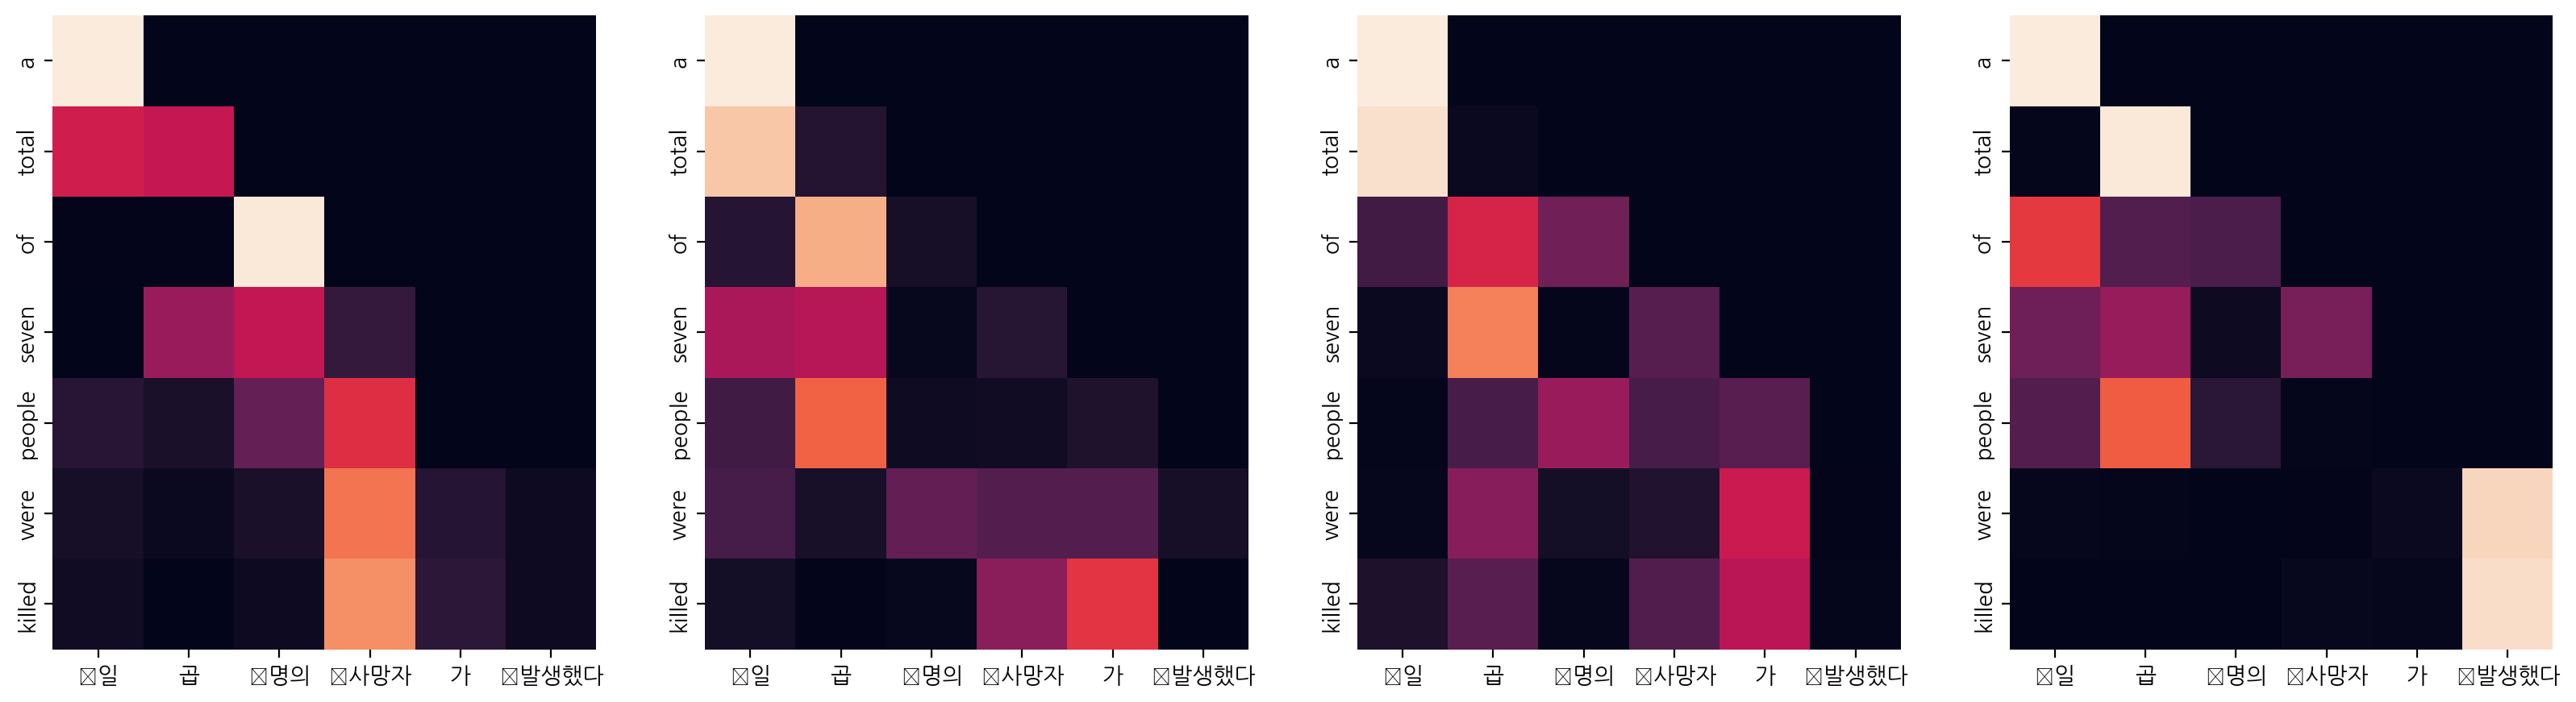

In [125]:

for idx, example in enumerate(examples):
    plot_attention = True
    translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention)
    print('='*50)

# Step 6. Bleu Score  Metrics 평가

In [61]:
import numpy as np
from collections import Counter
from nltk import ngrams

In [62]:
# 토큰화 된 문장(tokens)에서 n-gram을 카운트
def simple_count(tokens, n):
  return Counter(ngrams(tokens, n))

In [63]:
def count_clip(candidate, reference_list, n):
  # Ca 문장에서 n-gram 카운트
  ca_cnt = simple_count(candidate, n)
  max_ref_cnt_dict = dict()

  for ref in reference_list: 
    # Ref 문장에서 n-gram 카운트
    ref_cnt = simple_count(ref, n)

    # 각 Ref 문장에 대해서 비교하여 n-gram의 최대 등장 횟수를 계산.
    for n_gram in ref_cnt: 
      if n_gram in max_ref_cnt_dict:
        max_ref_cnt_dict[n_gram] = max(ref_cnt[n_gram], max_ref_cnt_dict[n_gram])
      else:
        max_ref_cnt_dict[n_gram] = ref_cnt[n_gram]

  return {
        # count_clip = min(count, max_ref_count)
        n_gram: min(ca_cnt.get(n_gram, 0), max_ref_cnt_dict.get(n_gram, 0)) for n_gram in ca_cnt
     }

In [64]:
def modified_precision(candidate, reference_list, n):
  clip_cnt = count_clip(candidate, reference_list, n) 
  total_clip_cnt = sum(clip_cnt.values()) # 분자

  cnt = simple_count(candidate, n)
  total_cnt = sum(cnt.values()) # 분모

  # 분모가 0이 되는 것을 방지
  if total_cnt == 0: 
    total_cnt = 1

  # 분자 : count_clip의 합, 분모 : 단순 count의 합 ==> 보정된 정밀도
  return (total_clip_cnt / total_cnt)

In [65]:
# Ca 길이와 가장 근접한 Ref의 길이를 리턴하는 함수
def closest_ref_length(candidate, reference_list):
  ca_len = len(candidate) # ca 길이
  ref_lens = (len(ref) for ref in reference_list) # Ref들의 길이
  # 길이 차이를 최소화하는 Ref를 찾아서 Ref의 길이를 리턴
  closest_ref_len = min(ref_lens, key=lambda ref_len: (abs(ref_len - ca_len), ref_len))
  return closest_ref_len

In [66]:
def brevity_penalty(candidate, reference_list):
  ca_len = len(candidate)
  ref_len = closest_ref_length(candidate, reference_list)

  if ca_len > ref_len:
    return 1

  # candidate가 비어있다면 BP = 0 → BLEU = 0.0
  elif ca_len == 0 :
    return 0
  else:
    return np.exp(1 - ref_len/ca_len)

In [78]:
def bleu_score(candidate, reference_list, weights=[1,0,0,0]):
  bp = brevity_penalty(candidate, reference_list) # 브레버티 패널티, BP

  p_n = [modified_precision(candidate, reference_list, n=n) for n, _ in enumerate(weights,start=1)] 
  # p1, p2, p3, ..., pn
  score = np.sum([w_i * np.log(p_i) if p_i != 0 else 0 for w_i, p_i in zip(weights, p_n)])
  return bp * np.exp(score)

소스코드로 작성된 Bleu와 nltk의 sentence_bleu 비교

In [82]:
from nltk.translate.bleu_score import sentence_bleu
reference = [
    'obama is president.',
    'citizens live in cities.',
    'coffee is not required.',
    'seven people were killed'
]
score = []

for idx, trans in enumerate(trans_list):
    ref = [reference[idx].split()]
    cand = trans.split()
    source_bleu_score = bleu_score(cand,ref) 
    sen_bleu_score = sentence_bleu(ref, cand, weights=(1,0,0,0))  #1,2,3,4-gram에 동일 가중치
    print(f'\n사람 번역: {reference[idx]} \n번역기: {trans} ')
    print(f'bleu_score:{source_bleu_score:.3f}   NLKT sentence_Bleu : {sen_bleu_score:.3f}')



사람 번역: obama is president. 
번역기: obama s margin of president barack obama is obama 
bleu_score:0.222   NLKT sentence_Bleu : 0.222

사람 번역: citizens live in cities. 
번역기: citizens live in cities 
bleu_score:0.750   NLKT sentence_Bleu : 0.750

사람 번역: coffee is not required. 
번역기: coffee shops don t need coffee 
bleu_score:0.167   NLKT sentence_Bleu : 0.167

사람 번역: seven people were killed 
번역기: a total of seven people were killed 
bleu_score:0.571   NLKT sentence_Bleu : 0.571


# 회고

- GRU기반의 Seq2Seq 모델 번역기 성능이 많이 좋지 않아 실망 했는데, Transformer를 하면서 그래도 좋은 성능의 번역들이 보여서 재미있었다. 
- 중간에 번역이 제대로 되는 문장이 있는데, 훈련을 계속 할 때마다 내용이 점점 달라져서 오히려 번역의 품질이 나빠지는 경향도 보였다. 
- 번역의 품질을 위해 BLEU Score를 구현해서 계산해 보았다. 

## 참고자료



https://jrc-park.tistory.com/273   
https://wikidocs.net/31695
